# Notes

This notebook plots a paper-ready version of the <DM> vs redshift curve in Pipe_LSS_Analysis_5.ipynb
    
Plots results against previous literature.
    
For Zhang et al, uses code from: zhang_free_parameter_plots.ipynb
    
It also plots the fractional DM contribution data from Pipe_LSS_Analysis_5.ipynb which was saved to a dictionary

# Imports 

In [1]:
import os
import fruitbat


import numpy as np
import illustris_python as il

from frbz import calcz
from frb.dm import igm
from charlie_TNG_tools import temp2u
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd


from scipy import interpolate
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
import scipy.stats as stats

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource
from astropy.modeling import models, fitting

import frbz
print(frbz.__file__)

/u/cwalker/git_python_downloads/Pol_DM_IGM_Charlie_Edit/frbz.py


# Functions

In [2]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100),density=True):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    density : [boolean] True or False: whether the histogram should normalise for the pdf or not.
    """
    
    return np.histogram(data,bins=bins,density=density)[0]

In [3]:
#function to darken colours in plots from: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
#function to get true subhalo id information

def newpIDshIDconverter(pipe_cell_pIDs,ChunkedPartIDs,ChunkedSubhIDs):
    """
    New version of the code which creates a set of subhalo IDs from a set of particle
    IDs.
    
    This version loops through each chunk of the simulation ID lists in turn searching
    for relevant particle and subhalo IDs. 
    
    Note: could be improved to be faster if, when all correct particle IDs are found, it
    does not need to search further chunks. This is not yet implemented.
    
    INPUTS:
    
    pipe_cell_pIDs : the particle ids of cells in a given pipe
    ChunkedPartIDs : list containing locations of the chunks of 
                     the particle ID list for all cells in the 
                     desired simulation. If all of these were loaded
                     into a single array, the result would be the
                     same as AllPartIDs in oldpIDshIDconverter().
    ChunkedSubhIDs : list containing locations of the chunks of 
                     the subhalo ID list for all cells in the 
                     desired simulation. If all of these were loaded
                     into a single array, the result would be the
                     same as AllPartIDs in oldpIDshIDconverter().
    
    RETURNS:
    
    pipe_cell_shIDs : the corresponding subhalo IDs for every particle IDs.

    
    """
    
    #create a set of particle IDs for the cells in this pipe
    PartID_Set = set(pipe_cell_pIDs.tolist())
    
    #initialise an array to contain all subhalo IDs in simulation
    pipe_cell_shIDs = np.ones(pipe_cell_pIDs.shape,dtype=int)*-1
    
    #print(ChunkedPartIDs)
    
    #load chunks of the all-simulation particle ID list
    for i in range(len(ChunkedPartIDs)):
        
        #True/False array of same shape as pipe data which allows 
        #us to extract the relevant IDs from each chunk
        TF_arr = np.full(pipe_cell_pIDs.shape, False) #begin with false, flip to true when chunk contains ID
        
        sim_inds = []#initialise an array to contain  positions of any cells in this chunk
        
        #get location of chunks to load
        PartFile_toload = ChunkedPartIDs[i] #all-simulation particle ID list chunk
        SubhFile_toload = ChunkedSubhIDs[i] #all-simulation subhalo ID list chunk
        
        #load the ID list chunks
        ChunkOfPartIDs = np.load(PartFile_toload) #particle chunk
        ChunkOfSubhIDs = np.load(SubhFile_toload) #subhalo chunk

        #loop over the particle IDs in the chunk
        for j, x in enumerate(ChunkOfPartIDs):
            
            #find if particle ID is also in the pipe
            if x in PartID_Set:
                                
                #find where that particle ID is in the pipe
                pipe_idx = np.where(pipe_cell_pIDs==x)
                
                #flip the True/False array index to True for this cell
                TF_arr[pipe_idx] = True
                
                #append the cell's corresponding chunk position
                sim_inds.append(j)
                
                #print(i,j,pipe_idx,x,ChunkOfSubhIDs[j])

            
        #convert all chunk position indices to array
        sim_inds = np.array(sim_inds)
        
        #record all corresponding subhalo IDs in this chunk
        #print(pipe_cell_shIDs[TF_arr])
        #print(sim_inds)
        #print(ChunkOfSubhIDs[sim_inds])
        if sim_inds.size>0:#only try this if the array is not empty
            pipe_cell_shIDs[TF_arr] = ChunkOfSubhIDs[sim_inds]
            

    return pipe_cell_shIDs

In [5]:
def zhang_distribution(DM_arr,redshift,interp_method='linterp'):
    """
    
    Function which calculates the Zhang+20 pIGM Zhang probability
    distribution for a desired DM range at a desired redshift.
    
    Distribution is Equation 10 in https://arxiv.org/abs/2011.14494
    
    Requires FRB python package from github
    
    INPUTS:
    
    DM_arr        : [array of floats] array of dispersion measures (in pc/cc)
                    to get the distribution for.
    redshift      : [float] redshift to calculate probability distribution for.
    interp_method : [str] if 'linterp', uses linear interpolation to calculate
                    fitting parameters
                    
    RETURNS:
    
    pIGM          : [array of floats] array of probabilities.
    
    """
    
    ##################################
    #calculate the fitting parameters#
    ##################################
    
    if interp_method == 'linterp': #via linear interpolation
        A = linterp_A(redshift)
        C0 = linterp_C0(redshift)
        sigmaDM = linterp_sigmaDM(redshift)
        #print('A={0}, C0={1}, sigmaDM={2}'.format(A,C0,sigmaDM))
        
    else:
        print('Error: invalid interpolation method')
        return
    
    #################
    #calculate Delta#
    #################
    
    average_DMIGM = igm.average_DM(redshift) #theoretical average DM for this redshift from Macquart relation
    average_DMIGM = average_DMIGM.value
    
    Delta = np.array(DM_arr)/average_DMIGM
    
    #######################
    #Calculate probability#
    #######################
    
    alpha = 3 #from zhang+20
    beta = 3 #from zhang+20
    
    amplitude = A * (Delta**(-1*beta))
    #print(amplitude)
    
    exponent_numerator  = -1*(((Delta**(-1*alpha))-C0)**2)
    #print(exponent_numerator)
    
    exponent_denominator = (2*alpha**2*sigmaDM**2)
    #print(exponent_denominator)
    
    exponent = exponent_numerator/exponent_denominator
    #print(exponent)
    
    pIGM = amplitude * np.exp(exponent)
    
    return pIGM

In [6]:
def dolag_distribution(DM_cosmo,redshift):
    """
    
    Function which calculates the Dolag+15 p(DM_cosmo|z) probability
    distribution for a desired DM range at a desired redshift.
    
    Distribution is Equation 6 in https://ui.adsabs.harvard.edu/abs/2015MNRAS.451.4277D/abstract
    
    Requires FRB python package from github
    
    INPUTS:
    
    DM_cosmo        : [array of floats] array of dispersion measures (in pc/cc)
                    to get the distribution for.
    redshift        : [float] redshift to calculate probability distribution for.

                    
    RETURNS:
    
    p_cosmo         : [array of floats] array of probabilities.
    
    """
    
    
    z = redshift #for easier calculation

    A_z    = ((2e-11) * (z**-9)) + ((1.3e-7)*(z**-4)) + ((5e-7)*((z-2.325)**2)) #A(z) factor
    
    DM_00z = ((-770)*(z**1.3)) + (31.2*np.sqrt(z)) #DM_00(z) factor
    
    DM_01z = -108 + (926*z) + (67*(z**3)) #DM_01(z) factor
    
    sig_z  = (126.9*z) + 2.03 - (27.4*(z**2)) #sigma(z) factor
    
    p_cosmo = A_z * ((DM_cosmo + DM_00z)**2) * np.exp(-1.*((DM_cosmo + DM_01z)/(sig_z)))
    
    return p_cosmo
    
    
    

# Load Macquart/Prochaska github theoretical+empirical relation

In [7]:
#get theory for next plot
#theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0])#,5.0])#,6.0,7.0,8.0, 9.0])
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0,5.0])#,6.0,7.0,8.0, 9.0])

print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


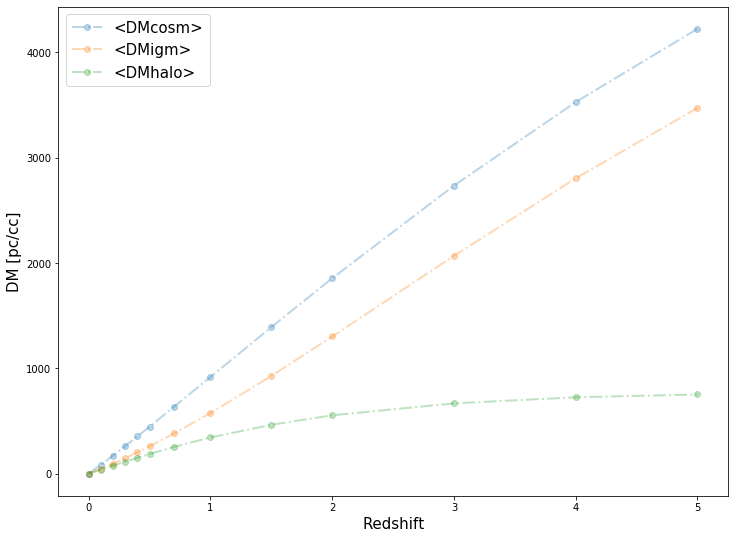

In [8]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()

# Load Pipe dDM/dz values

In [9]:
#############################
#Identify files to be loaded#
#############################

#simulation to load data for
sim_to_load = 'TNG300-1'

#path to simulation data
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)


#base directory containing pipe files
if sim_to_load!='TNG300-1': #for smaller simulations the pipes are stored in '.'
    pipeBasePath = './'
else: #for TNG300-1 the pipes are stored in /SpeedTest/
    pipeBasePath = './SpeedTest/'

#load the files from the base path
all_files = os.listdir(pipeBasePath)#for pipes created for smaller simulations

#.npy files
npy_files = [i for i in all_files if '.npy' in i]

#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz_Output' in i]

#correct simulation
dDMdz_files = [i for i in npy_files if sim_to_load in i]

#load version of data with impact factor details for all small simulations
if sim_to_load!='TNG300-1':
    dDMdz_files = [i for i in dDMdz_files if 'pID_test' in i]
else: #load version from speed tests for TNG300-1
     dDMdz_files = [i for i in dDMdz_files if 'SpeedTest' in i]
        
#list of snapshots wth data
snap_list = [int(i.split('_')[3]) for i in dDMdz_files]

#sort into ascending order
dDMdz_files = [x for _, x in sorted(zip(snap_list, dDMdz_files))]
snap_list.sort()

#reverse into descending order
dDMdz_files = dDMdz_files[::-1]
snap_list = snap_list[::-1]

#crop to redshift 5, because that is as far as the theory goes in FRB package.
#Note that after z=3 accuracy 'is not guaranteed'

#test on 20/10/22: include redshift 6 to reach redshift 5


#dDMdz_files = dDMdz_files[0:12]
dDMdz_files = dDMdz_files[0:13]
#snap_list = snap_list[0:12]
snap_list = snap_list[0:13]

#print to check
print(snap_list)
print(dDMdz_files)

[99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21, 17]
['Sim_TNG300-1_Snap_99_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_91_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_84_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_78_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_72_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_67_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_59_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_50_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_40_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_33_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_25_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_21_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_17_dDMdz_Output_SpeedTest.npy']


In [10]:
#############################
#Zhang method initialisation#
#############################

dDMdz_dict_Zhang = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Zhang = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Zhang = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Zhang = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Zhang  = {} #initialise dictionary to hold number of halo cells
fila_dict_Zhang  = {} #initialise dictionary to hold number of filament cells
void_dict_Zhang  = {} #initialise dictionary to hold number of void cells

##################################
#Pakmor Correction initialisation#
##################################

dDMdz_dict_Pakmor = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Pakmor = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Pakmor = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Pakmor = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Pakmor  = {} #initialise dictionary to hold number of halo cells
fila_dict_Pakmor  = {} #initialise dictionary to hold number of filament cells
void_dict_Pakmor  = {} #initialise dictionary to hold number of void cells

##############################
#Impact factor initialisation#
##############################

first_ShID_dict     = {} #initialise dictionary to hold the first subhalo ID in each pipe
unique_ShIDs_dict   = {} #initialise dictionary to hold all unique subhalo IDs in each pipe
closest_coords_dict = {} #initialise dictionary to extract pipe coordinates of closest approach to these IDs.

######################
#Other initialisation#
######################

snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

#######################################
#load the files into a data dictionary#
#######################################

#path to data
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/virgotng/universe/IllustrisTNG/{0}/output'.format(sim_to_load)

for i in range(len(dDMdz_files)):#loop over files

    #load and extract dats
    snapshot = dDMdz_files[i].split('_')[3] #extract snapshot number
    
    vals = np.load(pipeBasePath+dDMdz_files[i],allow_pickle=True).tolist() #extract values from file
    
    dDMdz_dict_Zhang[snapshot]=vals['dDMdz_Zhang']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key
    dDMdz_dict_Pakmor[snapshot]=vals['dDMdz_Pakmor']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key

    dDMdz_HaloDict_Zhang[snapshot]=vals['dDMdzHalo_Zhang']*u.pc*u.cm**-3 #do same for halo portion
    dDMdz_HaloDict_Pakmor[snapshot]=vals['dDMdzHalo_Pakmor']*u.pc*u.cm**-3 #do same for halo portion

    dDMdz_FilaDict_Zhang[snapshot]=vals['dDMdzFilament_Zhang']*u.pc*u.cm**-3 #do same for filament portion
    dDMdz_FilaDict_Pakmor[snapshot]=vals['dDMdzFilament_Pakmor']*u.pc*u.cm**-3 #do same for filament portion

    dDMdz_VoidDict_Zhang[snapshot]=vals['dDMdzVoid_Zhang']*u.pc*u.cm**-3 #do same for void portion
    dDMdz_VoidDict_Pakmor[snapshot]=vals['dDMdzVoid_Pakmor']*u.pc*u.cm**-3 #do same for void portion

    halo_dict_Zhang[snapshot]=np.array(vals['nHalo_Zhang']) #append number of halo cells to dictionary with snapshot number as key
    halo_dict_Pakmor[snapshot]=np.array(vals['nHalo_Pakmor']) #append number of halo cells to dictionary with snapshot number as key

    fila_dict_Zhang[snapshot]=np.array(vals['nFilament_Zhang']) #append number of filament cells to dictionary with snapshot number as key
    fila_dict_Pakmor[snapshot]=np.array(vals['nFilament_Pakmor']) #append number of filament cells to dictionary with snapshot number as key

    void_dict_Zhang[snapshot]=np.array(vals['nVoid_Zhang']) #append number of void cells to dictionary with snapshot number as key
    void_dict_Pakmor[snapshot]=np.array(vals['nVoid_Pakmor']) #append number of void cells to dictionary with snapshot number as key
 
    first_ShID_dict[snapshot]=np.array(vals['firstShID']) #append first subhalo ID of each pipe
    unique_ShIDs_dict[snapshot]=np.array(vals['uniqueShIDs']) #append all unique subhalo IDs in each pipe
    closest_coords_dict[snapshot]=np.array(vals['closestCoords']) #append closest los coords to these IDs

    header = il.groupcat.loadHeader(basePath,int(snapshot)) #extract simulation and snapshot header
    snap_redshifts[snapshot]=header['Redshift'] #get redshift at this snapshot
    snap_z_list.append(header['Redshift']) #append to array


#print(snap_redshifts['99'])    

#print('totals: {0} ({1})'.format(dDMdz_dict_Zhang['99'],dDMdz_dict_Pakmor['99']))
#print('sum of structures: {0} ({1})'.format(dDMdz_HaloDict_Zhang['99']+dDMdz_FilaDict_Zhang['99']+dDMdz_VoidDict_Zhang['99'],
#                                            dDMdz_HaloDict_Pakmor['99']+dDMdz_FilaDict_Pakmor['99']+dDMdz_VoidDict_Pakmor['99']))
#print(halo_dict_Zhang['99'])
#print(halo_dict_Zhang['99']+fila_dict_Zhang['99']+void_dict_Zhang['99'])
#print(len(snap_redshifts))

#print(halo_dict_Zhang)

#print(len(halo_dict_Zhang['99']),len(halo_dict_Zhang['91']))

#print('impact factor info:')
#print('first subhalo IDs: {0}'.format(first_ShID_dict['99']))
#print('(number unique first subhalos = {0}, uniques = {1})'.format(len(np.unique(first_ShID_dict['99'])),np.unique(first_ShID_dict['99'])))
#print('unique subhalos : {0}'.format(unique_ShIDs_dict['99']))
#print('closest coords to subhalos: {0}'.format(closest_coords_dict['99']))

In [11]:
print(dDMdz_dict_Zhang['99'].shape)

(5125,)


In [12]:
impact_factor_dict = {} # initialise dictionary

for i in range(len(snap_list)): #loop over snapshots
    snapshot = str(snap_list[i]) #get snapshot number
    print(snapshot)
    dists_snap = [] #initialise array to hold distances to every subhalo in every pipe in snapshot
    subhalos_snap = unique_ShIDs_dict[snapshot] #get snapshot's subhalos traversed
    closests_snap = closest_coords_dict[snapshot] #get closest coordinates to these snapshots
    #print(subhalos,closests)
    #print(subhalos_snap[1],closests_snap[1])
    for j in range(len(subhalos_snap)): #loop over all pipes
        dists_pipe = [] #initialise array to hold distances to every subhalo in this pipe
        subhalos_pipe = np.array(subhalos_snap[j])
        closests_pipe = np.array(closests_snap[j])
        #extract the ones which are not -1
        subhalos_pipe_notneg1 = subhalos_pipe[np.where(subhalos_pipe!=-1)]
        #print(subhalos_pipe,subhalos_pipe_notneg1,closests_pipe)
        #loop over subhalos in pipe which aren't -1 and get impact factors
        for k in range(len(subhalos_pipe_notneg1)): #loop over subhalos
            subhalo = subhalos_pipe_notneg1[k] #select subhalo
            subhalo_closestcoords = closests_pipe[k] #get closest coordinates
            subhalo_data = il.groupcat.loadSingle(basePath,int(snapshot),subhaloID=subhalo)#load subhalo data
            subhalo_pos = subhalo_data['SubhaloPos']
            MinDist = np.sqrt(((subhalo_closestcoords[0]-subhalo_pos[0])**2)+((subhalo_closestcoords[1]-subhalo_pos[1])**2)+((subhalo_closestcoords[2]-subhalo_pos[2])**2))
            dists_pipe.append(MinDist) #append distance to array
        dists_snap.append(np.array(dists_pipe)) #append pipe to array
    impact_factor_dict[snapshot] = np.array(dists_snap) #append snapshot to dictionary
    
print('done')


99
91
84
78
72
67
59
50
40
33
25
21
17
done


# Calculate

In [13]:
#calculate DMIGM(z) for a single line of sight according to paper

############
#Initialise#
############

x = snap_list

DMIGM_Zhang     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0
DMIGM_Pakmor     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0

DMIGM_Halo_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM
DMIGM_Halo_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM

DMIGM_Fila_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM
DMIGM_Fila_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM

DMIGM_Void_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM
DMIGM_Void_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM

HaloCells_Zhang = [0.] #initialise arrays to store the number of halo cells for the created LoS
HaloCells_Pakmor = [0.] #initialise arrays to store the number of halo cells for the created LoS

FilaCells_Zhang = [0.] #initialise arrays to store the number of filament cells for the created LoS
FilaCells_Pakmor = [0.] #initialise arrays to store the number of filament cells for the created LoS

VoidCells_Zhang = [0.] #initialise arrays to store the number of void cells for the created LoS
VoidCells_Pakmor = [0.] #initialise arrays to store the number of void cells for the created LoS

num_subhalos = [0.] #initialise array to store the  number of subhalos at each redshift for the created LoS

#####################
#loop over snapshots#
#####################

for i in range(len(x)-1): 
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for this redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id])))
    print(rand_idx_Zhang)
    #get the dDMdz values
    rand_dDMdz_Zhang = dDMdz_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Halo_Zhang = dDMdz_HaloDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Fila_Zhang = dDMdz_FilaDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Void_Zhang = dDMdz_VoidDict_Zhang[snap_id][rand_idx_Zhang]
    #get the cell values
    rand_nHalo_Zhang = halo_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nFila_Zhang = fila_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nVoid_Zhang = void_dict_Zhang[snap_id][rand_idx_Zhang]

    print('For Snapshot {0}'.format(snap_id))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang))
    print('dDM/dz Zhang values are',rand_dDMdz_Zhang,rand_dDMdz_Halo_Zhang+rand_dDMdz_Fila_Zhang+rand_dDMdz_Void_Zhang)
    print('cell values are',rand_nHalo_Zhang,rand_nFila_Zhang,rand_nVoid_Zhang)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id])))
    print(rand_idx_Pakmor)
    #get the dDMdz values
    rand_dDMdz_Pakmor = dDMdz_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Halo_Pakmor = dDMdz_HaloDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Fila_Pakmor = dDMdz_FilaDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Void_Pakmor = dDMdz_VoidDict_Pakmor[snap_id][rand_idx_Pakmor]
    #get the cell values
    rand_nHalo_Pakmor = halo_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nFila_Pakmor = fila_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nVoid_Pakmor = void_dict_Pakmor[snap_id][rand_idx_Pakmor]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor,rand_dDMdz_Halo_Pakmor+rand_dDMdz_Fila_Pakmor+rand_dDMdz_Void_Pakmor)    
    print('cell values are',rand_nHalo_Pakmor,rand_nFila_Pakmor,rand_nVoid_Pakmor)
    
    #############################
    #get the subhalo information#
    #############################
    
    rand_unique_ShIDs = np.array(unique_ShIDs_dict[snap_id][rand_idx_Zhang])
    rand_unique_ShIDs_notNeg1 = rand_unique_ShIDs[np.where(rand_unique_ShIDs!=-1)]
    rand_first_ShIDs = first_ShID_dict[snap_id][rand_idx_Zhang]
    rand_impactFacts = impact_factor_dict[snap_id][rand_idx_Zhang]
    print('unique subhalos are', rand_unique_ShIDs)
    print('ones not -1: {0}'.format(rand_unique_ShIDs_notNeg1))

    
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for next redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang_ = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Zhang_ = dDMdz_dict_Zhang[snap_id_][rand_idx_Zhang_]    
    rand_dDMdz_Halo_Zhang_ = dDMdz_HaloDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Fila_Zhang_ = dDMdz_FilaDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Void_Zhang_ = dDMdz_VoidDict_Zhang[snap_id_][rand_idx_Zhang_]
    #get the cell values
    rand_nHalo_Zhang_ = halo_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nFila_Zhang_ = fila_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nVoid_Zhang_ = void_dict_Zhang[snap_id_][rand_idx_Zhang_]
    print('For next redshift ({0}):'.format(snap_id_))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang_))    
    print('Ddm/dz Zhang values are',rand_dDMdz_Zhang_,rand_dDMdz_Halo_Zhang_+rand_dDMdz_Fila_Zhang_+rand_dDMdz_Void_Zhang_)
    print('cell values',rand_nHalo_Zhang_,rand_nFila_Zhang_,rand_nVoid_Zhang_)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor_ = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Pakmor_ = dDMdz_dict_Pakmor[snap_id_][rand_idx_Pakmor_]    
    rand_dDMdz_Halo_Pakmor_ = dDMdz_HaloDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Fila_Pakmor_ = dDMdz_FilaDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Void_Pakmor_ = dDMdz_VoidDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    #get the cell values
    rand_nHalo_Pakmor_ = halo_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nFila_Pakmor_ = fila_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nVoid_Pakmor_ = void_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor_))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor_,rand_dDMdz_Halo_Pakmor_+rand_dDMdz_Fila_Pakmor_+rand_dDMdz_Void_Pakmor_)
    print('cell values are',rand_nHalo_Pakmor_,rand_nFila_Pakmor_,rand_nVoid_Pakmor_)
    
    #############################
    #get the subhalo information#
    #############################
    
    rand_unique_ShIDs_ = np.array(unique_ShIDs_dict[snap_id_][rand_idx_Zhang_])
    rand_unique_ShIDs_notNeg1_ = rand_unique_ShIDs_[np.where(rand_unique_ShIDs_!=-1)]
    rand_first_ShIDs_ = first_ShID_dict[snap_id_][rand_idx_Zhang_]
    rand_impactFacts_ = impact_factor_dict[snap_id_][rand_idx_Zhang_]
    print('unique subhalos are', rand_unique_ShIDs_)
    print('ones not -1: {0}'.format(rand_unique_ShIDs_notNeg1_))
    
    ######################
    #create the DM values#
    ######################
    
    nextDM_Zhang     = DMIGM_Zhang[i] + ((0.5*(rand_dDMdz_Zhang+rand_dDMdz_Zhang_)) * (snap_z_ -  snap_z))
    nextDM_Pakmor     = DMIGM_Pakmor[i] + ((0.5*(rand_dDMdz_Pakmor+rand_dDMdz_Pakmor_)) * (snap_z_ -  snap_z))

    nextHaloDM_Zhang = DMIGM_Halo_Zhang[i] + ((0.5*(rand_dDMdz_Halo_Zhang+rand_dDMdz_Halo_Zhang_)) * (snap_z_ -  snap_z))
    nextHaloDM_Pakmor = DMIGM_Halo_Pakmor[i] + ((0.5*(rand_dDMdz_Halo_Pakmor+rand_dDMdz_Halo_Pakmor_)) * (snap_z_ -  snap_z))

    nextFilaDM_Zhang = DMIGM_Fila_Zhang[i] + ((0.5*(rand_dDMdz_Fila_Zhang+rand_dDMdz_Fila_Zhang_)) * (snap_z_ -  snap_z))
    nextFilaDM_Pakmor = DMIGM_Fila_Pakmor[i] + ((0.5*(rand_dDMdz_Fila_Pakmor+rand_dDMdz_Fila_Pakmor_)) * (snap_z_ -  snap_z))

    nextVoidDM_Zhang = DMIGM_Void_Zhang[i] + ((0.5*(rand_dDMdz_Void_Zhang+rand_dDMdz_Void_Zhang_)) * (snap_z_ -  snap_z))
    nextVoidDM_Pakmor = DMIGM_Void_Pakmor[i] + ((0.5*(rand_dDMdz_Void_Pakmor+rand_dDMdz_Void_Pakmor_)) * (snap_z_ -  snap_z))
    
    ################################################################################
    #create the number of LSS cell value by averaging those of the two chosen pipes#
    ################################################################################
    
    nextHalo_Zhang = (0.5*(rand_nHalo_Zhang+rand_nHalo_Zhang_))
    nextHalo_Pakmor = (0.5*(rand_nHalo_Pakmor+rand_nHalo_Pakmor_))

    nextFila_Zhang = (0.5*(rand_nFila_Zhang+rand_nFila_Zhang_))
    nextFila_Pakmor = (0.5*(rand_nFila_Pakmor+rand_nFila_Pakmor_))
    
    nextVoid_Zhang = (0.5*(rand_nVoid_Zhang+rand_nVoid_Zhang_))
    nextVoid_Pakmor = (0.5*(rand_nVoid_Pakmor+rand_nVoid_Pakmor_))
    
    ############################################################################################
    #create the number of subhalos traversed value by averaging those from the two chosen pipes#
    ############################################################################################
    
    next_num_Subhalos = (0.5*(len(rand_unique_ShIDs_notNeg1)+len(rand_unique_ShIDs_notNeg1_)))
    print('average number of non- -1 subhalos: {0}'.format(next_num_Subhalos))
    
    ##################
    #Append to arrays#
    ##################
    
    DMIGM_Zhang.append(nextDM_Zhang)
    DMIGM_Pakmor.append(nextDM_Pakmor)
    
    DMIGM_Halo_Zhang.append(nextHaloDM_Zhang)
    DMIGM_Halo_Pakmor.append(nextHaloDM_Pakmor)

    DMIGM_Fila_Zhang.append(nextFilaDM_Zhang)
    DMIGM_Fila_Pakmor.append(nextFilaDM_Pakmor)

    DMIGM_Void_Zhang.append(nextVoidDM_Zhang)
    DMIGM_Void_Pakmor.append(nextVoidDM_Pakmor)
    
    HaloCells_Zhang.append(nextHalo_Zhang)
    HaloCells_Pakmor.append(nextHalo_Pakmor)

    FilaCells_Zhang.append(nextFila_Zhang)
    FilaCells_Pakmor.append(nextFila_Pakmor)

    VoidCells_Zhang.append(nextVoid_Zhang)
    VoidCells_Pakmor.append(nextVoid_Pakmor)
    
    num_subhalos.append(next_num_Subhalos)
    
#################################################
#create the fractions of LSS cells at each point#
#################################################

fraction_Halo_Zhang = np.array(HaloCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Halo_Pakmor = np.array(HaloCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Fila_Zhang = np.array(FilaCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Fila_Pakmor = np.array(FilaCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Void_Zhang = np.array(VoidCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Void_Pakmor = np.array(VoidCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

#########################
#Convert to numpy arrays#
#########################

DMIGM_Zhang = np.array(DMIGM_Zhang)
DMIGM_Pakmor = np.array(DMIGM_Pakmor)

DMIGM_Halo_Zhang = np.array(DMIGM_Halo_Zhang)
DMIGM_Halo_Pakmor = np.array(DMIGM_Halo_Pakmor)

DMIGM_Fila_Zhang = np.array(DMIGM_Fila_Zhang)
DMIGM_Fila_Pakmor = np.array(DMIGM_Fila_Pakmor)

DMIGM_Void_Zhang = np.array(DMIGM_Void_Zhang)
DMIGM_Void_Pakmor = np.array(DMIGM_Void_Pakmor)

#################################################################
#Create the total number of subhalos traversed by this sightline#
#################################################################
print('number of subhaloes traversed: {0}'.format(num_subhalos))
tot_subhalos_traversed = np.sum(num_subhalos)
print('total: {0}'.format(tot_subhalos_traversed))

print(' tests')
print(len(x),len(DMIGM_Zhang))
print(HaloCells_Zhang)
print('DM_tests')
print(DMIGM_Zhang,DMIGM_Halo_Zhang+DMIGM_Fila_Zhang+DMIGM_Void_Zhang)
print('fracion tests')
print(fraction_Halo_Zhang)
print(fraction_Fila_Zhang)
print(fraction_Void_Zhang)
print(fraction_Halo_Zhang+fraction_Fila_Zhang+fraction_Void_Zhang)

0
99 91
2.220446049250313e-16 0.09940180263022191
89
For Snapshot 99
The random Zhang id is 89
dDM/dz Zhang values are 384.9567351758094 pc / cm3 384.9567351758094 pc / cm3
cell values are 0 1574 8426
2658
The random Pakmor id is 2658
dDM/dz Pakmor values are 751.1783159580818 pc / cm3 751.1783163164122 pc / cm3
cell values are 11 2237 7752
unique subhalos are [1]
ones not -1: [1]
For next redshift (91):
The random Zhang id is 3203
Ddm/dz Zhang values are 616.9223356614419 pc / cm3 616.922335661442 pc / cm3
cell values 4 1557 8439
The random Pakmor id is 4129
dDM/dz Pakmor values are 1345.8509255178683 pc / cm3 1345.8509317993005 pc / cm3
cell values are 11 2402 7587
unique subhalos are [1]
ones not -1: [1]
average number of non- -1 subhalos: 1.0
1
91 84
0.09940180263022191 0.19728418237600986
1803
For Snapshot 91
The random Zhang id is 1803
dDM/dz Zhang values are 783.7149088149071 pc / cm3 783.7149088149071 pc / cm3
cell values are 0 1809 8191
3376
The random Pakmor id is 3376
dDM/dz

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:236: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in true_divide


# Calculate DM for many sightlines

In [14]:
nlos = 10000000 #number of lines of sight

################################################
#create an array of randomly drawn dDMdz values#
################################################

########################################################################
#array of randomly generated indices to select pipes from each snapshot#
########################################################################

idx_arr_Zhang  = np.array([np.random.choice(np.arange(len(dDMdz_dict_Zhang[str(snap_id)])),size=nlos) for snap_id in snap_list])
idx_arr_Pakmor = np.array([np.random.choice(np.arange(len(dDMdz_dict_Pakmor[str(snap_id)])),size=nlos) for snap_id in snap_list])

#################################
#the dDMdz values of these pipes#
#################################

dDMdz_arr_Zhang  = np.array([dDMdz_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_arr_Pakmor = np.array([dDMdz_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

###################################################
#the halo, filament and void values of these pipes#
###################################################

dDMdz_HaloArr_Zhang = np.array([dDMdz_HaloDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_HaloArr_Pakmor = np.array([dDMdz_HaloDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_FilaArr_Zhang = np.array([dDMdz_FilaDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_FilaArr_Pakmor = np.array([dDMdz_FilaDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_VoidArr_Zhang = np.array([dDMdz_VoidDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_VoidArr_Pakmor = np.array([dDMdz_VoidDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

print('check: the difference between the totals and the sum of the structures should be zero')
print(np.sum(dDMdz_arr_Zhang - (dDMdz_HaloArr_Zhang+dDMdz_FilaArr_Zhang+dDMdz_VoidArr_Zhang)))
print(np.sum(dDMdz_arr_Pakmor - (dDMdz_HaloArr_Pakmor+dDMdz_FilaArr_Pakmor+dDMdz_VoidArr_Pakmor)))

#############################
#also extract arrays for LSS#
#############################

#the number of halo cells which made this pipe
los_Halo_arr_Zhang  = np.array([halo_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Halo_arr_Pakmor = np.array([halo_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of filament cells which made this pipe
los_Fila_arr_Zhang  = np.array([fila_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Fila_arr_Pakmor = np.array([fila_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of void cells which made this pipe
los_Void_arr_Zhang  = np.array([void_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Void_arr_Pakmor = np.array([void_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])
print('VOID:{0}'.format(los_Void_arr_Pakmor.shape))

##################################
#also extract arrays for subhalos#
##################################

#the unique subhalo ID values traversed by this pipe
los_ShID_arr = np.array([unique_ShIDs_dict[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])
#the impact factors to subhalos traversed by this pipe:
if_arr = np.array([impact_factor_dict[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

######################################################################################################
#calculate the number of impact factors (aka number of non- negative one subhalos traversed) by pipes#
######################################################################################################

n_all_ifs = [] #initialise array to hold if count for every pipe in every snapshot

for i in range(len(if_arr)): #loop over each snapshot
    n_pipe_ifs = [] #initialise array to hold this snapshot's pipes' if counts
    snap_ifs = if_arr[i] #this snapshot's pipes' if values
    
    for j in range(len(snap_ifs)): #loop over this snapshot's pipes
        pipe_ifs = snap_ifs[j] #this pipe's if values
        n_ifs = len(pipe_ifs) #this pipe's if count (aka the number of subhalos traversed by pipe)
        n_pipe_ifs.append(n_ifs) #append if count to list
        
    n_pipe_ifs=np.array(n_pipe_ifs) #convert list of if counts to array
    n_all_ifs.append(n_pipe_ifs) #append this snapshot's if counts to list
n_all_ifs=np.array(n_all_ifs) #convert list of snapshot if counts to array


print('check: impact factors for {0} pipes: {1}'.format(if_arr.shape,if_arr))
print('and check: the corresponding {0} if counts: {1}'.format(n_all_ifs.shape,n_all_ifs))

###########################
#create array of redshifts#
###########################

z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

####################################################
#perform the calculation to get DM at each redshift#
####################################################

DM_arr_Zhang  = (0.5*(dDMdz_arr_Zhang[:,:][0:-1]+dDMdz_arr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total
DM_arr_Pakmor = (0.5*(dDMdz_arr_Pakmor[:,:][0:-1]+dDMdz_arr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total

DM_HaloArr_Zhang  = (0.5*(dDMdz_HaloArr_Zhang[:,:][0:-1]+dDMdz_HaloArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos
DM_HaloArr_Pakmor = (0.5*(dDMdz_HaloArr_Pakmor[:,:][0:-1]+dDMdz_HaloArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos

DM_FilaArr_Zhang  = (0.5*(dDMdz_FilaArr_Zhang[:,:][0:-1]+dDMdz_FilaArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments
DM_FilaArr_Pakmor = (0.5*(dDMdz_FilaArr_Pakmor[:,:][0:-1]+dDMdz_FilaArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments

DM_VoidArr_Zhang  = (0.5*(dDMdz_VoidArr_Zhang[:,:][0:-1]+dDMdz_VoidArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids
DM_VoidArr_Pakmor = (0.5*(dDMdz_VoidArr_Pakmor[:,:][0:-1]+dDMdz_VoidArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids

######################################################################
#perform the calculation to get the average LSS data at each redshift#
######################################################################

av_Hal_arr_Zhang  = (0.5*(los_Halo_arr_Zhang[:,:][0:-1]+los_Halo_arr_Zhang[:,:][1:]))
av_Hal_arr_Pakmor = (0.5*(los_Halo_arr_Pakmor[:,:][0:-1]+los_Halo_arr_Pakmor[:,:][1:]))

av_Fil_arr_Zhang  = (0.5*(los_Fila_arr_Zhang[:,:][0:-1]+los_Fila_arr_Zhang[:,:][1:]))
av_Fil_arr_Pakmor = (0.5*(los_Fila_arr_Pakmor[:,:][0:-1]+los_Fila_arr_Pakmor[:,:][1:]))

av_Voi_arr_Zhang  = (0.5*(los_Void_arr_Zhang[:,:][0:-1]+los_Void_arr_Zhang[:,:][1:]))
av_Voi_arr_Pakmor = (0.5*(los_Void_arr_Pakmor[:,:][0:-1]+los_Void_arr_Pakmor[:,:][1:]))

print('check: the sum of these should be 10,000 for every pipe at every z\n',
      'Zhang',
       av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang,
       np.mean(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang),
      'Pakmor',
       av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor,
       np.mean(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor))

##################################################################################
#perform calculation to get the average number of impact factors at each redshift#
##################################################################################

av_n_all_ifs  = (0.5*(n_all_ifs[:,:][0:-1]+n_all_ifs[:,:][1:]))
print('check average if shape: {0}'.format(av_n_all_ifs.shape))


##############################################################################
#perform the calculation to turn these into fractions of LSS at each redshift#
##############################################################################

frac_Hal_arr_Zhang  = av_Hal_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Hal_arr_Pakmor = av_Hal_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Fil_arr_Zhang  = av_Fil_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Fil_arr_Pakmor = av_Fil_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Voi_arr_Zhang  = av_Voi_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Voi_arr_Pakmor = av_Voi_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

print('check: the sum of these {0} should be 1 for every pipe at every z\n'.format(frac_Hal_arr_Zhang.shape),
      'Zhang',
      frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang,
      np.sum((frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang),axis=0),
      'Pakmor',
      frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor,
      np.sum((frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor),axis=0))

#######################################
#add the initial condition of DM=0@z=0#
#######################################

#DMs
DM_arr_Zhang      = np.insert(DM_arr_Zhang,0,np.zeros(nlos),axis=0)
DM_arr_Pakmor     = np.insert(DM_arr_Pakmor,0,np.zeros(nlos),axis=0)

Hal_DM_arr_Zhang  = np.insert(DM_HaloArr_Zhang,0,np.zeros(nlos),axis=0)
Hal_DM_arr_Pakmor = np.insert(DM_HaloArr_Pakmor,0,np.zeros(nlos),axis=0)

Fil_DM_arr_Zhang  = np.insert(DM_FilaArr_Zhang,0,np.zeros(nlos),axis=0)
Fil_DM_arr_Pakmor = np.insert(DM_FilaArr_Pakmor,0,np.zeros(nlos),axis=0)

Voi_DM_arr_Zhang  = np.insert(DM_VoidArr_Zhang,0,np.zeros(nlos),axis=0)
Voi_DM_arr_Pakmor = np.insert(DM_VoidArr_Pakmor,0,np.zeros(nlos),axis=0)

#number fractions
frac_Hal_arr_Zhang  = np.insert(frac_Hal_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Hal_arr_Pakmor = np.insert(frac_Hal_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Fil_arr_Zhang  = np.insert(frac_Fil_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Fil_arr_Pakmor = np.insert(frac_Fil_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Voi_arr_Zhang  = np.insert(frac_Voi_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Voi_arr_Pakmor = np.insert(frac_Voi_arr_Pakmor,0,np.zeros(nlos),axis=0)

#subhalos traversed by each pipe
av_n_all_ifs        = np.insert(av_n_all_ifs,0,np.zeros(nlos),axis=0)

print('Zhang check: the DM_arr / the sum of the structures should be 1',DM_arr_Zhang/(Hal_DM_arr_Zhang+Fil_DM_arr_Zhang+Voi_DM_arr_Zhang))
print('Pakmor check: the DM_arr / the sum of the structures should be 1',DM_arr_Pakmor/(Hal_DM_arr_Pakmor+Fil_DM_arr_Pakmor+Voi_DM_arr_Pakmor))

##############################################################
#perform the cumulative sum to get the cDM for each light ray#
##############################################################

cDM_arr_Zhang = np.cumsum(DM_arr_Zhang,axis=0) #total
cDM_arr_Pakmor  = np.cumsum(DM_arr_Pakmor,axis=0) #total

Hal_cDM_arr_Zhang  = np.cumsum(Hal_DM_arr_Zhang,axis=0) #halo
Hal_cDM_arr_Pakmor = np.cumsum(Hal_DM_arr_Pakmor,axis=0) #halo

Fil_cDM_arr_Zhang  = np.cumsum(Fil_DM_arr_Zhang,axis=0) #filament
Fil_cDM_arr_Pakmor = np.cumsum(Fil_DM_arr_Pakmor,axis=0) #filament

Voi_cDM_arr_Zhang  = np.cumsum(Voi_DM_arr_Zhang,axis=0) #void
Voi_cDM_arr_Pakmor = np.cumsum(Voi_DM_arr_Pakmor,axis=0) #void

#subhalos traversed by each pipe
cIF_arr = np.cumsum(av_n_all_ifs,axis=0)

print('Zhang check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Zhang/(Hal_cDM_arr_Zhang+Fil_cDM_arr_Zhang+Voi_cDM_arr_Zhang))
print('Pakmor check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Pakmor/(Hal_cDM_arr_Pakmor+Fil_cDM_arr_Pakmor+Voi_cDM_arr_Pakmor))


#print(DM_arr)
#print(cDM_arr)
print(cDM_arr_Zhang.shape)
print(cDM_arr_Pakmor.shape)
print('subhalos traversed shape check: {0}'.format(cIF_arr.shape))

check: the difference between the totals and the sum of the structures should be zero
6.014462883285887e-08 pc / cm3
-458899245.9465043 pc / cm3
VOID:(13, 10000000)
check: impact factors for (13, 10000000, 1) pipes: [[[170000.31991481]
  [ 62700.54293773]
  [142087.90819536]
  ...
  [ 50619.19979612]
  [ 61901.80132875]
  [ 46276.27165427]]

 [[134813.71943009]
  [ 34929.23093557]
  [ 35729.63303439]
  ...
  [163472.48674104]
  [ 87125.3087029 ]
  [ 23873.1624531 ]]

 [[153941.33804482]
  [ 50416.62479192]
  [123690.92007396]
  ...
  [ 66424.70562798]
  [105319.89267848]
  [ 33168.62929862]]

 ...

 [[174792.67080472]
  [ 65341.64271772]
  [170945.67159661]
  ...
  [ 52031.33436498]
  [113055.58442845]
  [ 42780.02084637]]

 [[ 82175.68092057]
  [ 92194.27627042]
  [ 63219.20520556]
  ...
  [ 85949.15608793]
  [134247.93716379]
  [ 80342.43733989]]

 [[ 19917.90193777]
  [194316.77355936]
  [ 67644.10305333]
  ...
  [147765.06346537]
  [  8489.51434204]
  [ 79286.62009757]]]
and check:

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Zhang check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
Pakmor check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
Zhang check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
Pakmor check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1

# Get DM statistics

In [15]:
########
#totals#
########

#NOTE: BIG QUESTION ABOUT STDV: Should it be calculated cumulatively?????

mean_cDM_arr_Zhang  = np.mean(cDM_arr_Zhang,axis=1) #mean
mean_cDM_arr_Pakmor = np.mean(cDM_arr_Pakmor,axis=1) #mean

medi_cDM_arr_Zhang  = np.median(cDM_arr_Zhang,axis=1) #median
medi_cDM_arr_Pakmor = np.median(cDM_arr_Pakmor,axis=1) #median

stdv_cDM_arr_Zhang  = np.std(cDM_arr_Zhang,axis=1) #standard deviation
stdv_cDM_arr_Pakmor = np.std(cDM_arr_Pakmor,axis=1) #standard deviation

print('Shapes:', cDM_arr_Pakmor.shape,mean_cDM_arr_Pakmor.shape)



#######
#halos#
#######

mean_Hal_cDM_arr_Zhang  = np.mean(Hal_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Hal_cDM_arr_Pakmor = np.mean(Hal_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Hal_cDM_arr_Zhang  = np.median(Hal_cDM_arr_Zhang,axis=1) #median of DMs
medi_Hal_cDM_arr_Pakmor = np.median(Hal_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Hal_cDM_arr_Zhang  = np.std(Hal_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Hal_cDM_arr_Pakmor = np.std(Hal_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Hal_arr_Zhang  = np.mean(frac_Hal_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Hal_arr_Pakmor = np.mean(frac_Hal_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Hal_arr_Zhang  = np.median(frac_Hal_arr_Zhang,axis=1) #median of number fractions
medi_frac_Hal_arr_Pakmor = np.median(frac_Hal_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Hal_arr_Zhang  = np.std(frac_Hal_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Hal_arr_Pakmor = np.std(frac_Hal_arr_Pakmor,axis=1) #standard deviation of number fractions

###########
#filaments#
###########

mean_Fil_cDM_arr_Zhang  = np.mean(Fil_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Fil_cDM_arr_Pakmor = np.mean(Fil_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Fil_cDM_arr_Zhang  = np.median(Fil_cDM_arr_Zhang,axis=1) #median of DMs
medi_Fil_cDM_arr_Pakmor = np.median(Fil_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Fil_cDM_arr_Zhang  = np.std(Fil_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Fil_cDM_arr_Pakmor = np.std(Fil_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Fil_arr_Zhang  = np.mean(frac_Fil_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Fil_arr_Pakmor = np.mean(frac_Fil_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Fil_arr_Zhang  = np.median(frac_Fil_arr_Zhang,axis=1) #median of number fractions
medi_frac_Fil_arr_Pakmor = np.median(frac_Fil_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Fil_arr_Zhang  = np.std(frac_Fil_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Fil_arr_Pakmor = np.std(frac_Fil_arr_Pakmor,axis=1) #standard deviation of number fractions

#######
#voids#
#######

mean_Voi_cDM_arr_Zhang  = np.mean(Voi_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Voi_cDM_arr_Pakmor = np.mean(Voi_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Voi_cDM_arr_Zhang  = np.median(Voi_cDM_arr_Zhang,axis=1) #median of DMs
medi_Voi_cDM_arr_Pakmor = np.median(Voi_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Voi_cDM_arr_Zhang  = np.std(Voi_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Voi_cDM_arr_Pakmor = np.std(Voi_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Voi_arr_Zhang = np.mean(frac_Voi_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Voi_arr_Pakmor = np.mean(frac_Voi_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Voi_arr_Zhang = np.median(frac_Voi_arr_Zhang,axis=1) #median of number fractions
medi_frac_Voi_arr_Pakmor = np.median(frac_Voi_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Voi_arr_Zhang = np.std(frac_Voi_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Voi_arr_Pakmor = np.std(frac_Voi_arr_Pakmor,axis=1) #standard deviation of number fractions



##############
#DM Fractions#
##############

frac_cDM_Hal = Hal_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Halos
frac_cDM_Fil = Fil_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Filaments
frac_cDM_Voi = Voi_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Voids
print('Check: sum of fractions should equal 1: {0}'.format(frac_cDM_Hal+frac_cDM_Fil+frac_cDM_Voi))


#stats of these DM fractions
mean_frac_cDM_Hal = np.mean(frac_cDM_Hal,axis=1)   #means
mean_frac_cDM_Fil = np.mean(frac_cDM_Fil,axis=1)   #means
mean_frac_cDM_Voi = np.mean(frac_cDM_Voi,axis=1)   #means
medi_frac_cDM_Hal = np.median(frac_cDM_Hal,axis=1) #medians
medi_frac_cDM_Fil = np.median(frac_cDM_Fil,axis=1) #medians
medi_frac_cDM_Voi = np.median(frac_cDM_Voi,axis=1) #medians
stdv_frac_cDM_Hal = np.std(frac_cDM_Hal,axis=1)    #standard deviations
stdv_frac_cDM_Fil = np.std(frac_cDM_Fil,axis=1)    #standard deviations
stdv_frac_cDM_Voi = np.std(frac_cDM_Voi,axis=1)    #standard deviations



print('Mean cDM: ',mean_cDM_arr_Zhang,mean_cDM_arr_Pakmor)
print('Median cDM: ',medi_cDM_arr_Zhang,medi_cDM_arr_Pakmor)
print('Standard deviation of cDM: ',stdv_cDM_arr_Zhang, stdv_cDM_arr_Pakmor)

Shapes: (13, 10000000) (13,)
Check: sum of fractions should equal 1: [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
Mean cDM:  [   0.           92.57730903  188.09479349  288.86429676  393.45352818
  500.6778826   708.3726821  1021.32135923 1528.52678765 2015.70523336
 2894.94891387 3680.26250502 4368.84260066] pc / cm3 [   0.           92.62371256  188.15652389  288.72222589  393.117723
  500.36947364  708.09141126 1020.67278178 1525.88082773 2011.33923212
 2889.49945518 3674.10958618 4362.17720315] pc / cm3
Median cDM:  [   0.           77.41246379  162.9307513   256.94060104  356.48780153
  460.07886767  661.0520367   961.20270343 1452.97214039 1930.70940896
 2805.10805577 3591.54499571 4282.24955519] pc / cm3 [   0.           77.44800704  163.00179153  257.02387375  356.5611646
  460.10165425  661.13971914  961.30428316 1453.08753104 1930.

# Plot

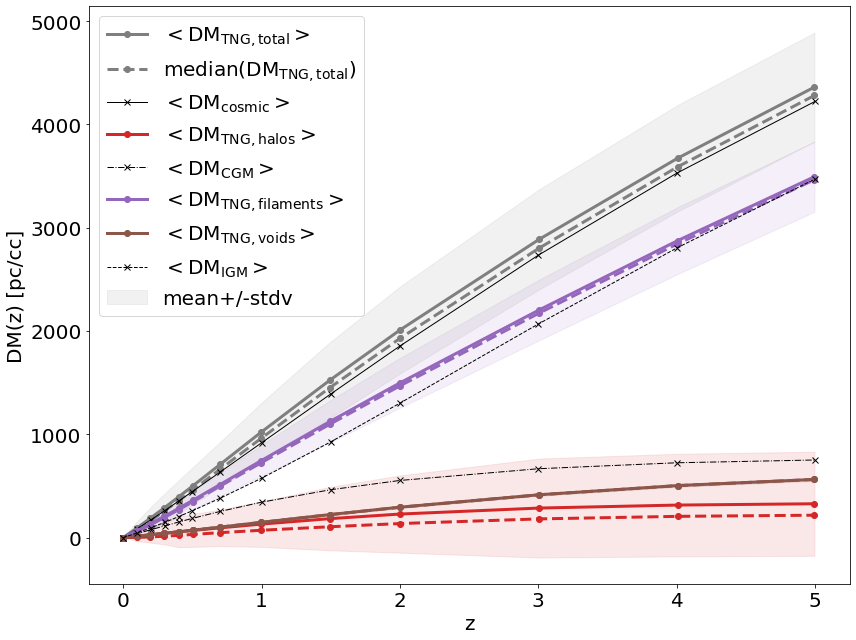

In [16]:
##################
#initialise plots#
##################

fig = plt.figure(figsize=(12,9))


ax2 = fig.add_subplot(111)
ax2.set_xlabel('z',fontsize=20)
ax2.set_ylabel('DM(z) [pc/cc]',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

#############
#Plot theory#
#############

ax2.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,total}}>$')
ax2.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='--',label=r'${\rm median(DM_{TNG,total})}$')
ax2.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.1,color='C7',label='mean+/-stdv')
ax2.plot(theory_z_2,cosm_theory_2,marker='x',color='k',ls='-',lw=1,alpha=1,label=r'$<{\rm DM_{cosmic}}>$')

ax2.plot(snap_z_list,mean_Hal_cDM_arr_Pakmor,marker='o',color='C3',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,halos}}>$')
ax2.plot(snap_z_list,medi_Hal_cDM_arr_Pakmor,marker='o',color='C3',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,alpha=0.1,color='C3')

ax2.plot(theory_z_2,halo_theory_2,marker='x',color='k',ls='-.',lw=1,alpha=1,label=r'$<{\rm DM_{CGM}}>$')

ax2.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,filaments}}>$')
ax2.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,alpha=0.1,color='C4')

ax2.plot(snap_z_list,mean_Voi_cDM_arr_Pakmor,marker='o',color='C5',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,voids}}>$')
ax2.plot(snap_z_list,medi_Voi_cDM_arr_Pakmor,marker='o',color='C5',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,alpha=0.1,color='C5')

ax2.plot(theory_z_2,igm_theory_2,marker='x',color='k',ls='--',lw=1,alpha=1,label=r'$<{\rm DM_{IGM}}>$')



ax2.legend(fontsize=15)

##########
#plot DMs#
##########

#pakmor






ax2.legend(fontsize=20)



plt.tight_layout()
plt.savefig('Paper_Plot_DM_{0}.png'.format(sim_to_load),format='png')
plt.show()

# More complex plot comparing to previous work

In [17]:
#relation for Jarozynski relation (https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.1637J/abstract)

#redshifts
j_z_vals = [0.,1.,2.,3.,4.,5.]

#<DM>
j_dm_vals = [0.,905.,1803.,2649.,3431.,4136.]

In [18]:
### fitting parameters for Zhang et al relation (https://ui.adsabs.harvard.edu/abs/2021ApJ...906...49Z/abstract)


z_z = [0.1,
     0.2,
     0.3,
     0.4,
     0.5,
     0.7,1.0,1.5,2.0,2.4,3.0,3.5,4.0,4.4,5.0,5.2,5.5,5.8,6.0,6.5,7.0,8.0,9.0]

#A
z_A = [0.04721,
     0.005693,
     0.003584,
     0.002876,
     0.002423,
     0.001880,
     0.001456,
     0.001098,
     0.0009672,
     0.0009220,
     0.0008968,
     0.0008862,
     0.0008826,
     0.0008827,0.0008834,0.0008846,0.0008863,0.0008878,0.0008881,0.0008881,0.0008881,0.0008881,0.0008881]

#C0
z_C0 = [-13.17,
      -1.008,
      0.596,
      1.010,
      1.127,
      1.170,
      1.189,
      1.163,
      1.162,
      1.142,
      1.119,
      1.104,
      1.092,
      1.084,
      1.076,1.073,1.070,1.067,1.066,1.066,1.066,1.066,1.066]



#sigmaDM
z_sigmaDM = [2.554,
           1.118,
           0.7043,
           0.5158,
           0.4306,
           0.3595,
           0.3044,
           0.2609,
           0.2160,
           0.1857,
           0.1566,
           0.1385,
           0.1233,
           0.1134,
           0.1029,
           0.09918,0.09481,0.09072,0.08971,0.08960,0.08952,0.08944,0.08941]

#functions which generate fitting parameters by linearly interpolating zhang values

#A
linterp_A = interpolate.interp1d(z_z,z_A)

#C0
linterp_C0 = interpolate.interp1d(z_z,z_C0)

#sigmaDM
linterp_sigmaDM = interpolate.interp1d(z_z,z_sigmaDM)

In [19]:
#initialise for Zhang calculations

z_z_vals  = [0] #initialise array to hold zhang <DM> values
z_dm_vals = [0] #initialise array to hold zhang z values

DM_list = np.linspace(0.001,10000,100000000) #list of DMs to get probability for
interp_method = 'linterp' #interpolation method to be used when ceating probability distributions

#loop over snapshot redshifts, 
for redshift in [0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0,5.0]: 
    
    #calculate probability of chosen DMs
    p=zhang_distribution(DM_list,redshift,interp_method) #get probability distribution
    
    #store most likely DM. Note: this isn't completely accurate as we aren't finding 
    #the true peak, just the closest DM to it
    z_z_vals.append(redshift)
    z_dm_vals.append(DM_list[np.argmax(p)])
                             
                             

[4.41645670e+001 3.82915654e+001 3.31066545e+001 ... 1.63609972e-294
 1.52698084e-294 1.42513957e-294]
peak DM: 58.0
peak p: 0.9521593247193308
[3.94314754e-002 3.70188187e-002 3.47426664e-002 ... 6.13822919e-163
 5.91052923e-163 5.69127578e-163]
peak DM: 134.0
peak p: 0.00010995866913869382
[3.97603534e-003 3.81777088e-003 3.66544189e-003 ... 8.16295918e-115
 7.95052513e-115 7.74361934e-115]
peak DM: 219.0
peak p: 3.351725501854831e-06
[1.26362474e-03 1.22620581e-03 1.18984212e-03 ... 5.40327630e-90
 5.29387931e-90 5.18669711e-90]
peak DM: 311.0
peak p: 4.304801508857153e-07
[6.30049137e-04 6.15124690e-04 6.00539355e-04 ... 6.28448147e-75
 6.17947453e-75 6.07622201e-75]
peak DM: 408.0
peak p: 9.993893891645602e-08
[2.66685137e-04 2.62112876e-04 2.57616530e-04 ... 9.90669821e-58
 9.78163383e-58 9.65814808e-58]
peak DM: 613.0
peak p: 1.1294763360918176e-08
[8.90023499e-05 8.78913038e-05 8.67938075e-05 ... 2.42388923e-45
 2.40065124e-45 2.37763599e-45]
peak DM: 942.0
peak p: 6.3715477415

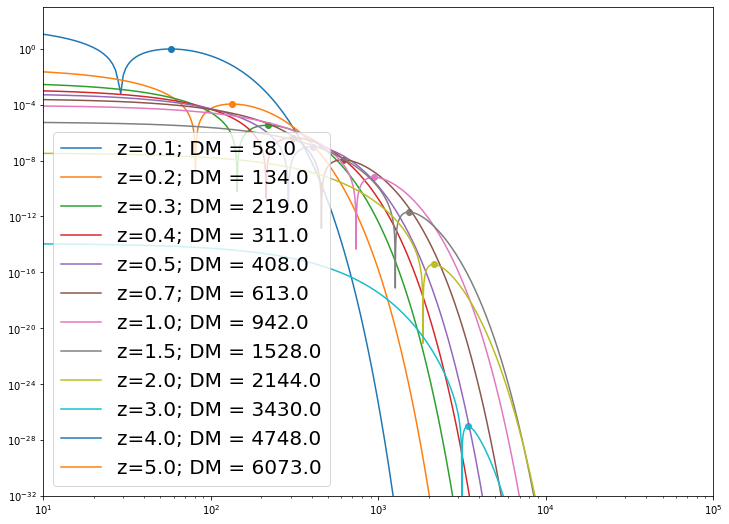

In [20]:
##NOTE: I DON'T THINK I"VE REPRODUCEED THE DOLAG CURVES CORRECTLY YET!
#THE AMPLITUDES OF THE PEAKS DON't MATCH FIGURE 4!

#initialise for Dolag calculations
from scipy.signal import find_peaks

d_z_vals  = [0.] #initialise array to hold dolag <DM> values
d_dm_vals = [0.] #initialise array to hold dolag z values

DM_list = np.linspace(1,10000,10000) #list of DMs to get probability for

#initialise figure
fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(111)
ax.set_xlim([10,1e5])
ax.set_ylim([1e-32,1e3])
ax.set_xscale('log')
ax.set_yscale('log')

#loop over snapshot redshifts, 
for redshift in [0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0,5.0]: #tng snapshot DMs for our work
#for redshift in [0.066,0.137,0.213,0.293,0.379,0.470,0.568,0.672,0.783]: #the dolag DMs for testing   
    #calculate probability of chosen DMs
    p=dolag_distribution(DM_list,redshift) #get probability distribution
    
    print(p)
    
    #store most likely DM. Note: this isn't completely accurate as we aren't finding 
    #the true peak, just the closest DM to it
    
    #find peak (note: np.argmax doesn't work because the shape of the equation
    #only fits the DM curve at a certain point (see paragraph under eqn 10
    #and plots for reference))
    
    
    peaks = find_peaks(p)
    peaks=peaks[0] #extract locations of peaks
    peaks=peaks[0] #extract only first peak in case of multiple peaks
    print('peak DM: {0}'.format(DM_list[peaks]))
    print('peak p: {0}'.format(p[peaks]))
    
    #plot for reference
    ax.plot(DM_list,p,label='z={0}; DM = {1}'.format(redshift,DM_list[peaks]))
    ax.scatter(DM_list[peaks],p[peaks])
    
    
    #save to array for use
    d_z_vals.append(redshift)
    d_dm_vals.append(DM_list[peaks])

plt.legend(fontsize=20)
plt.show()

In [21]:
#perform fruitbat calculations


fb_dm_vals = np.linspace(.01,5000,20)

fb_ioka_z_vals = [fruitbat.Frb(i).calc_redshift(method="Ioka2003", cosmology="Planck18") for i in fb_dm_vals]
fb_inoue_z_vals = [fruitbat.Frb(i).calc_redshift(method="Inoue2004", cosmology="Planck18") for i in fb_dm_vals]
fb_zhang_z_vals = [fruitbat.Frb(i).calc_redshift(method="Zhang2018", cosmology="Planck18") for i in fb_dm_vals]
fb_batten_z_vals = [fruitbat.Frb(i).calc_redshift(method="Batten2021", cosmology="Planck18") for i in fb_dm_vals]

print(fb_batten_z_vals)

[<Quantity nan>, <Quantity 0.2920632>, <Quantity 0.53966521>, <Quantity 0.77710601>, <Quantity 1.0158586>, <Quantity 1.26145342>, <Quantity 1.51394704>, <Quantity 1.77563416>, <Quantity 2.04612828>, <Quantity 2.32787957>, <Quantity 2.6042241>, <Quantity 2.78359182>, <Quantity 2.83472186>, <Quantity 2.8240258>, <Quantity 2.79293637>, <Quantity 2.78328496>, <Quantity 2.78828433>, <Quantity 2.74871903>, <Quantity 2.77151788>, <Quantity 2.7269573>]


/u/cwalker/.local/lib/python3.7/site-packages/fruitbat/utils.py:227: RuntimeWarning: invalid value encountered in true_divide
  normed_cumsum = cumsum / cumsum[-1]


In [22]:
# perform pol calculations
pol_dm_vals  = np.linspace(0,5000,200)

pol_z_vals = [calcz(i,1,0.01)[0] for i in pol_dm_vals] #note: only works in ipython in dir: /raven/u/cwalker/git_python_downloads/Pol_DM_IGM
print(pol_z_vals)

[0.007545756756756757, 0.007545756756756757, 0.007545756756756757, 0.22201353063063065, 0.34244206566566565, 0.40411147777777773, 0.43880499339339335, 0.49401817627627626, 0.5280927345345345, 0.5579677141141142, 0.5893616093593593, 0.6108145387387387, 0.63849502002002, 0.6613008541541542, 0.6846637036036036, 0.7026376693693694, 0.7271518861861862, 0.7400730721721722, 0.7588460885885886, 0.7786218579579579, 0.7983953401401401, 0.8117440279779781, 0.8254750259759759, 0.8402890598598598, 0.8544554801801801, 0.8758739227727728, 0.8765416898898899, 0.890493362962963, 0.9055647524024024, 0.9207512251751752, 0.9365701385885886, 0.9446332032532532, 0.9596436126126127, 0.9607887396396396, 0.9761297030030031, 0.9932808143143144, 1.0013410385385386, 1.0106449576576577, 1.0187888858358358, 1.0437770351351352, 1.0438955234734735, 1.0450472125125125, 1.0617158438938938, 1.0702340288288288, 1.0712567129129131, 1.0889301481981981, 1.1073466840840842, 1.1082305388888891, 1.1171976064064064, 1.126585348

In [23]:
# perform zhu and feng calculations

zhu_z_vals  = np.linspace(0,5,10)

def zhu_DM_func(z):
    """
    Equation 8 from Zhu and feng 2021.
    
    Returns the fit to the median of DMIGM+DMhalos for a given redshift
    
    Paper reference: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...95Z/abstract
    
    Inputs:
    
    z : redshift
    
    Returns:
    
    DM : Median of DMIGM(z)+DMhalos(z) at z as inferred by the paper
    
    """
    
    logDM = 2.92 + (1.11*np.log10(z)) - (0.03*((np.log10(z))**2))
    
    return 10**logDM

zhu_dm_vals = zhu_DM_func(zhu_z_vals)



/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


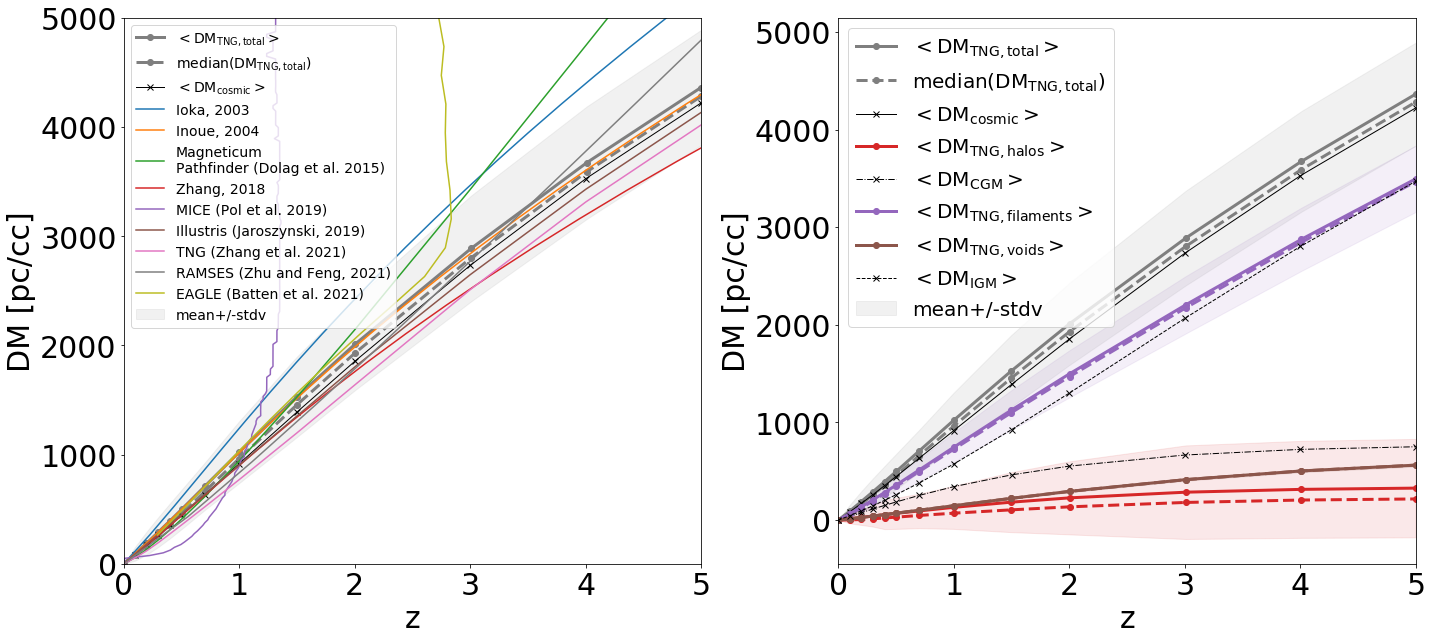

In [24]:
##################
#initialise plots#
##################

fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('z',fontsize=30)
ax1.set_ylabel('DM [pc/cc]',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xlim([0,5.])
ax1.set_ylim([0,5000])

ax2 = fig.add_subplot(122)
ax2.set_xlabel('z',fontsize=30)
ax2.set_ylabel('DM [pc/cc]',fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_xlim([0,5.])

###############################################
#plot TNG DM total vs previous work (fruitbat)#
###############################################

ax1.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,total}}>$')
ax1.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='--',label=r'${\rm median(DM_{TNG,total})}$')
ax1.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.1,color='C7',label='mean+/-stdv')


ax1.plot(theory_z_2,cosm_theory_2,marker='x',color='k',ls='-',lw=1,alpha=1,label=r'$<{\rm DM_{cosmic}}>$')

#ioka: https://ui.adsabs.harvard.edu/abs/2003ApJ...598L..79I/abstract
ax1.plot(fb_ioka_z_vals,fb_dm_vals,label='Ioka, 2003')

#inoue: https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..999I/abstract
ax1.plot(fb_inoue_z_vals,fb_dm_vals,label='Inoue, 2004')

#dolag: https://ui.adsabs.harvard.edu/abs/2015MNRAS.451.4277D/abstract
ax1.plot(d_z_vals,d_dm_vals,label='Magneticum\nPathfinder (Dolag et al. 2015)')

#zhang: https://ui.adsabs.harvard.edu/abs/2018ApJ...867L..21Z/abstract
ax1.plot(fb_zhang_z_vals,fb_dm_vals,label='Zhang, 2018')

#pol: https://ui.adsabs.harvard.edu/abs/2019ApJ...886..135P/abstract
#ax1.plot(pol_z_vals,pol_dm_vals*(np.array(pol_z_vals)+1),label='MICE (Pol et al. 2019)')
ax1.plot(pol_z_vals,pol_dm_vals,label='MICE (Pol et al. 2019)')

#jaroszynski: https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.1637J/abstract
ax1.plot(j_z_vals,j_dm_vals,label='Illustris (Jaroszynski, 2019)')


#zhang: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...49Z/abstract
ax1.plot(z_z_vals,z_dm_vals,label='TNG (Zhang et al. 2021)')

#zhu: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...95Z/abstract
ax1.plot(zhu_z_vals,zhu_dm_vals,label='RAMSES (Zhu and Feng, 2021)')

#batten: https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5356B/abstract
ax1.plot(fb_batten_z_vals,fb_dm_vals,label='EAGLE (Batten et al. 2021)')



ax1.legend(fontsize=14,loc=2)



#############################################################################
#Plot breakdowns vs theoretical+empirical DMcosmic + breakdowns (FRB github)#
#############################################################################

ax2.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,total}}>$')
ax2.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',color='C7',lw=3,alpha=1,ls='--',label=r'${\rm median(DM_{TNG,total})}$')
ax2.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.1,color='C7',label='mean+/-stdv')
ax2.plot(theory_z_2,cosm_theory_2,marker='x',color='k',ls='-',lw=1,alpha=1,label=r'$<{\rm DM_{cosmic}}>$')

ax2.plot(snap_z_list,mean_Hal_cDM_arr_Pakmor,marker='o',color='C3',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,halos}}>$')
ax2.plot(snap_z_list,medi_Hal_cDM_arr_Pakmor,marker='o',color='C3',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,alpha=0.1,color='C3')

ax2.plot(theory_z_2,halo_theory_2,marker='x',color='k',ls='-.',lw=1,alpha=1,label=r'$<{\rm DM_{CGM}}>$')

ax2.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,filaments}}>$')
ax2.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,alpha=0.1,color='C4')

ax2.plot(snap_z_list,mean_Voi_cDM_arr_Pakmor,marker='o',color='C5',lw=3,alpha=1,ls='-',label=r'$<{\rm DM_{TNG,voids}}>$')
ax2.plot(snap_z_list,medi_Voi_cDM_arr_Pakmor,marker='o',color='C5',lw=3,alpha=1,ls='--')
ax2.fill_between(snap_z_list,mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,alpha=0.1,color='C5')

ax2.plot(theory_z_2,igm_theory_2,marker='x',color='k',ls='--',lw=1,alpha=1,label=r'$<{\rm DM_{IGM}}>$')



ax2.legend(fontsize=15)

##########
#plot DMs#
##########

#pakmor






ax2.legend(fontsize=20)



plt.tight_layout()
plt.savefig('Paper_Plot_DM_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Print new version with logged axes for paper

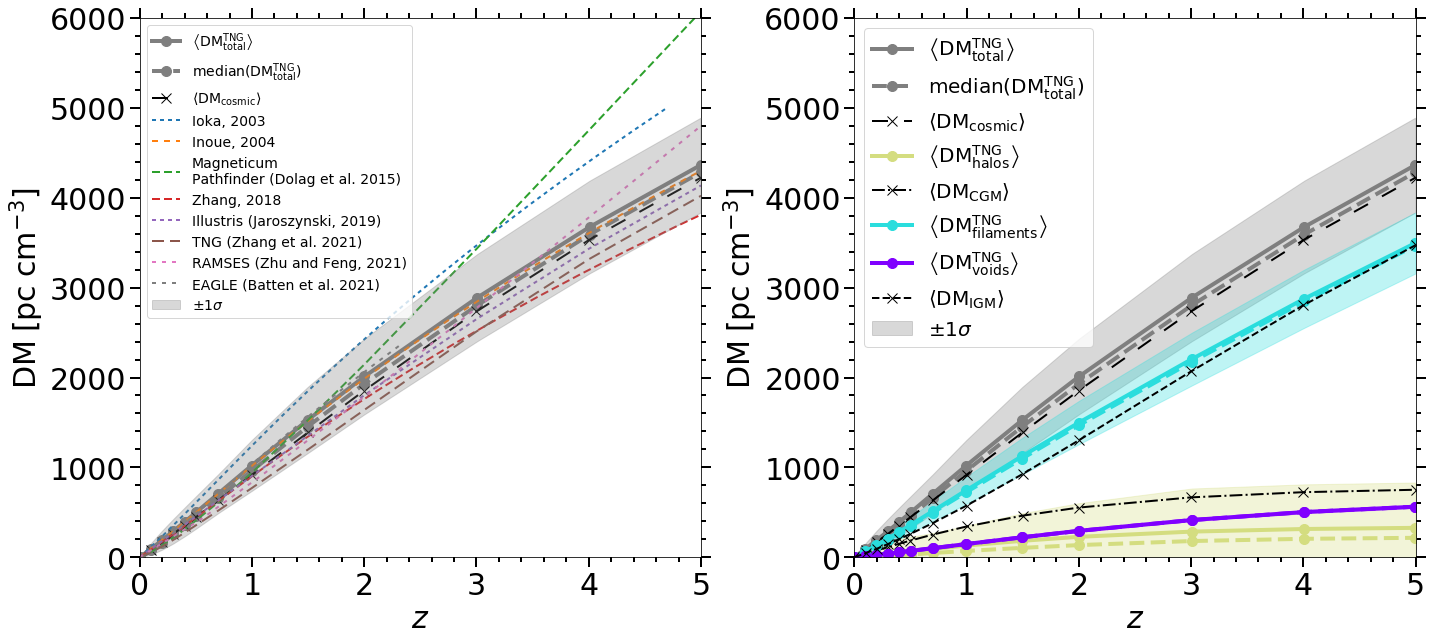

In [45]:
##################
#initialise plots#
##################
col = plt.cm.rainbow(np.linspace(0,1,4)) #create a list of colours from the colourmap which match those from plot in Paper_Plots_IF_vs_DM_3.ipynb

fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.set_xlabel(r'$z$',fontsize=30)
ax1.set_ylabel(r'${\rm DM\;[pc\;cm^{-3}]}$',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xlim([0,5.])
ax1.set_ylim([0,6000])
#ax1.set_ylim([50,5000])
#ax1.set_yscale('log')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax1.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r'$z$',fontsize=30)
ax2.set_ylabel(r'${\rm DM\;[pc\;cm^{-3}]}$',fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_xlim([0,5.])
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax2.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax2.xaxis.get_ticklocs(minor=True)
ax2.minorticks_on()
ax2.set_ylim([0,6000])



###############################################
#plot TNG DM total vs previous work (fruitbat)#
###############################################

ax1.plot(snap_z_list,
         mean_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='-',zorder=1,
         label=r'$\left<{\rm DM^{TNG}_{total}}\right>$')
ax1.plot(snap_z_list,
         medi_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='--',zorder=2,
         label=r'${\rm median(DM^{TNG}_{total})}$')
ax1.fill_between(snap_z_list,
                 mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,
                 mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.3,color='C7',zorder=3,
                 label=r'$\pm1\sigma$')


ax1.plot(theory_z_2,
         cosm_theory_2,
         marker='x',markersize=10,color='k',ls='-',lw=2,alpha=1,dashes=(8,8),
         label=r'$\left<{\rm DM_{cosmic}}\right>$')

#ioka: https://ui.adsabs.harvard.edu/abs/2003ApJ...598L..79I/abstract
ax1.plot(fb_ioka_z_vals,fb_dm_vals,label='Ioka, 2003',
        lw=2,ls='-.',dashes=(2, 2))

#inoue: https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..999I/abstract
ax1.plot(fb_inoue_z_vals,fb_dm_vals,label='Inoue, 2004',
        lw=2,ls='--',dashes=(3, 3))

#dolag: https://ui.adsabs.harvard.edu/abs/2015MNRAS.451.4277D/abstract
ax1.plot(d_z_vals,d_dm_vals,label='Magneticum\nPathfinder (Dolag et al. 2015)',
        lw=2,ls='-.',dashes=(4, 2))

#zhang: https://ui.adsabs.harvard.edu/abs/2018ApJ...867L..21Z/abstract
ax1.plot(fb_zhang_z_vals,fb_dm_vals,label='Zhang, 2018',
        lw=2,ls='--',dashes=(4, 2))

#pol: https://ui.adsabs.harvard.edu/abs/2019ApJ...886..135P/abstract
#ax1.plot(pol_z_vals,pol_dm_vals*(np.array(pol_z_vals)+1),label='MICE (Pol et al. 2019)')
#ax1.plot(pol_z_vals,pol_dm_vals,label='MICE (Pol et al. 2019)')

#jaroszynski: https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.1637J/abstract
ax1.plot(j_z_vals,j_dm_vals,label='Illustris (Jaroszynski, 2019)',
        lw=2,ls=':',dashes=(2, 2))


#zhang: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...49Z/abstract
ax1.plot(z_z_vals,z_dm_vals,label='TNG (Zhang et al. 2021)',
        lw=2,ls='--',dashes=(6,3))

#zhu: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...95Z/abstract
ax1.plot(zhu_z_vals,zhu_dm_vals,label='RAMSES (Zhu and Feng, 2021)',
        lw=2,ls=':',dashes=(2,3))

#batten: https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5356B/abstract
ax1.plot(fb_batten_z_vals[0:10],fb_dm_vals[0:10],label='EAGLE (Batten et al. 2021)',
        lw=2,ls='-.',dashes=(2,3))


ax1.legend(fontsize=14,loc=2)



#############################################################################
#Plot breakdowns vs theoretical+empirical DMcosmic + breakdowns (FRB github)#
#############################################################################

ax2.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{total}}\right>$')
ax2.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='--',label=r'${\rm median(DM^{TNG}_{total})}$')
ax2.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.3,color='C7',label=r'$\pm1\sigma$')
ax2.plot(theory_z_2,cosm_theory_2,marker='x',markersize=10,dashes=(8,8),color='k',ls='-',lw=2,alpha=1,label=r'$\left<{\rm DM_{cosmic}}\right>$')

ax2.plot(snap_z_list,
         mean_Hal_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[2],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{halos}}\right>$')
ax2.plot(snap_z_list,
         medi_Hal_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[2],lw=4,alpha=1,ls='--')
ax2.fill_between(snap_z_list,
                 mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,
                 mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,
                 alpha=0.3,color=col[2])

ax2.plot(theory_z_2,halo_theory_2,marker='x',markersize=10,color='k',ls='-.',lw=2,alpha=1,label=r'$\left<{\rm DM_{CGM}}\right>$')

ax2.plot(snap_z_list,
         mean_Fil_cDM_arr_Zhang,
         marker='o',markersize=10,color=col[1],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{filaments}}\right>$')
ax2.plot(snap_z_list,
         medi_Fil_cDM_arr_Zhang,
         marker='o',markersize=10,color=col[1],lw=4,alpha=1,ls='--')
ax2.fill_between(snap_z_list,
                 mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,
                 mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,
                 alpha=0.3,color=col[1])

ax2.plot(snap_z_list,
         mean_Voi_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[0],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{voids}}\right>$')
ax2.plot(snap_z_list,
         medi_Voi_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[0],lw=4,alpha=1,ls='--')
ax2.fill_between(snap_z_list,
                 mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,
                 mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,
                 alpha=0.3,color=col[0])

ax2.plot(theory_z_2,igm_theory_2,marker='x',markersize=10,color='k',ls='--',lw=2,alpha=1,label=r'$\left<{\rm DM_{IGM}}\right>$')



ax2.legend(fontsize=15)

##########
#plot DMs#
##########

#pakmor






ax2.legend(fontsize=20)



plt.tight_layout()
plt.savefig('Paper_Plot_DM_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Print results for paper table

In [26]:
#TNG mean DM (redshift, mean DM, stdv)
print('\n Mean TNG DM (z, mean stdv):\n')
for i in (list(zip(snap_z_list,mean_cDM_arr_Pakmor.value,stdv_cDM_arr_Pakmor.value))):
    print('{0:.2f}\,{1:.2f}\,({2:.2f})'.format(i[0],i[1],i[2]))
    
#Halos mean DM (z, mean, stdv)
print('\n Mean halos DM (z, mean stdv):\n')
for i in (list(zip(snap_z_list,mean_Hal_cDM_arr_Pakmor.value,stdv_Hal_cDM_arr_Pakmor.value))):
    print('{0:.2f}\,{1:.2f}\,({2:.2f})'.format(i[0],i[1],i[2]))
    
#Fils mean DM (z, mean, stdv)
print('\n Mean fils DM (z, mean stdv):\n')
for i in (list(zip(snap_z_list,mean_Fil_cDM_arr_Pakmor.value,stdv_Fil_cDM_arr_Pakmor.value))):
    print('{0:.2f}\,{1:.2f}\,({2:.2f})'.format(i[0],i[1],i[2]))
    
#Voids mean DM (z, mean, stdv)
print('\n Mean voids DM (z, mean stdv):\n')
for i in (list(zip(snap_z_list,mean_Voi_cDM_arr_Pakmor.value,stdv_Voi_cDM_arr_Pakmor.value))):
    print('{0:.2f}\,{1:.2f}\,({2:.2f})'.format(i[0],i[1],i[2]))


 Mean TNG DM (z, mean stdv):

0.00\,0.00\,(0.00)
0.10\,92.62\,(63.32)
0.20\,188.16\,(104.92)
0.30\,288.72\,(135.70)
0.40\,393.12\,(160.05)
0.50\,500.37\,(180.49)
0.70\,708.09\,(216.31)
1.00\,1020.67\,(282.79)
1.50\,1525.88\,(367.74)
2.00\,2011.34\,(420.56)
3.01\,2889.50\,(484.46)
4.01\,3674.11\,(515.17)
5.00\,4362.18\,(527.17)

 Mean halos DM (z, mean stdv):

0.00\,0.00\,(0.00)
0.10\,13.66\,(47.62)
0.20\,27.25\,(76.33)
0.30\,41.67\,(107.64)
0.40\,55.99\,(148.25)
0.50\,69.33\,(159.22)
0.70\,94.03\,(176.31)
1.00\,130.39\,(220.19)
1.50\,183.57\,(306.69)
2.00\,227.91\,(374.18)
3.01\,285.97\,(479.33)
4.01\,314.87\,(496.70)
5.00\,327.58\,(504.09)

 Mean fils DM (z, mean stdv):

0.00\,0.00\,(0.00)
0.10\,65.83\,(29.20)
0.20\,134.27\,(50.87)
0.30\,206.70\,(66.44)
0.40\,282.42\,(78.74)
0.50\,360.88\,(89.29)
0.70\,513.78\,(112.46)
1.00\,745.02\,(150.51)
1.50\,1125.39\,(203.33)
2.00\,1499.43\,(241.07)
3.01\,2205.82\,(293.67)
4.01\,2876.14\,(323.70)
5.00\,3494.52\,(339.22)

 Mean voids DM (z, mean

# Load fractional DM contribution data

 Note: this data was created by Pipe_LSS_Analysis_5.ipynb

In [31]:
#load data dictionary with arrays needed for plotting
read_fig_arrays = np.load('fract_DM_fig_arrays.npy',allow_pickle='TRUE').item()
print(read_fig_arrays.keys())

dict_keys(['snap_z_list', 'mean_Fil_cDM_arr_Pakmor', 'mean_cDM_arr_Pakmor', 'Fil_upper_bound', 'Fil_lower_bound', 'mean_Voi_cDM_arr_Pakmor', 'Voi_upper_bound', 'Voi_lower_bound', 'mean_Hal_cDM_arr_Pakmor', 'Hal_upper_bound', 'Hal_lower_bound'])


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


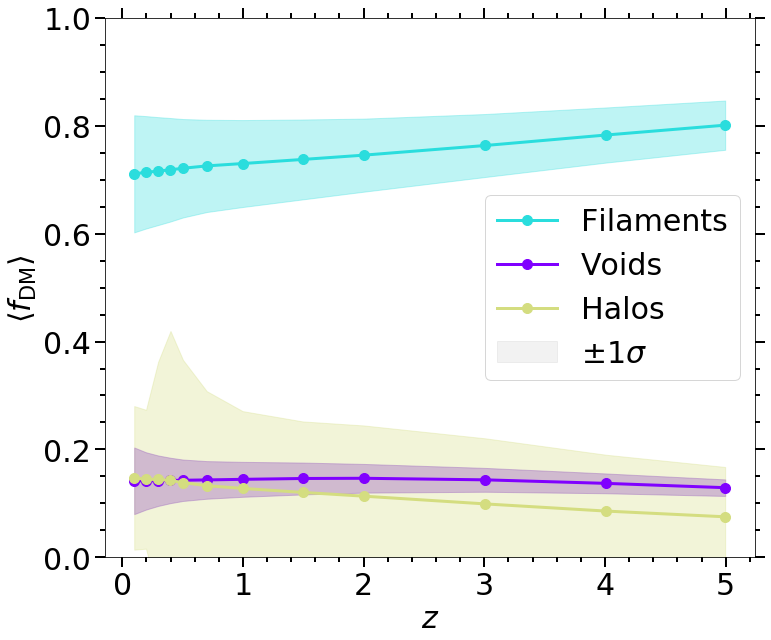

In [37]:
#test plot

###################
#initialise figure#
###################
col = plt.cm.rainbow(np.linspace(0,1,4)) #create a list of colours from the colourmap which match those from plot in Paper_Plots_IF_vs_DM_3.ipynb


fig = plt.figure(figsize=(20,9))

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r'$z$',fontsize=30)
ax2.set_ylabel(r'$\left<f_{\rm DM}\right>$',fontsize=30)
ax2.set_ylim([0,1])
ax2.set_xlabel(r'$z$',fontsize=30)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax2.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax2.xaxis.get_ticklocs(minor=True)
ax2.tick_params(axis='x', which='minor')
ax2.minorticks_on()

#################
#Do the plotting#
#################

#plot average filamentary contribution as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Fil_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[1],label='Filaments')

#plot stdv of filamentary contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Fil_upper_bound'],
                 read_fig_arrays['Fil_lower_bound'],
                 alpha=0.3,color=col[1])

#plot average void contributions as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Voi_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[0],label='Voids')

#plot stdv of void contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Voi_upper_bound'],
                 read_fig_arrays['Voi_lower_bound'],
                 alpha=0.3,color=col[0])

#also plot placeholder for legend purposes
ax2.fill_between(snap_z_list,
                 read_fig_arrays['Voi_upper_bound'],
                 read_fig_arrays['Voi_lower_bound'],
                 alpha=0.1,color='gray',label=r'$\pm1\sigma$')

#plot average halo contributions as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Hal_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[2],label='Halos')

#plot stdv of halo contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Hal_upper_bound'],
                 read_fig_arrays['Hal_lower_bound'],
                 alpha=0.3,color=col[2])


ax2.legend(fontsize=30)

plt.tight_layout()
plt.show()

# Plot DM evolution and fractional DM evolution in one subplot

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


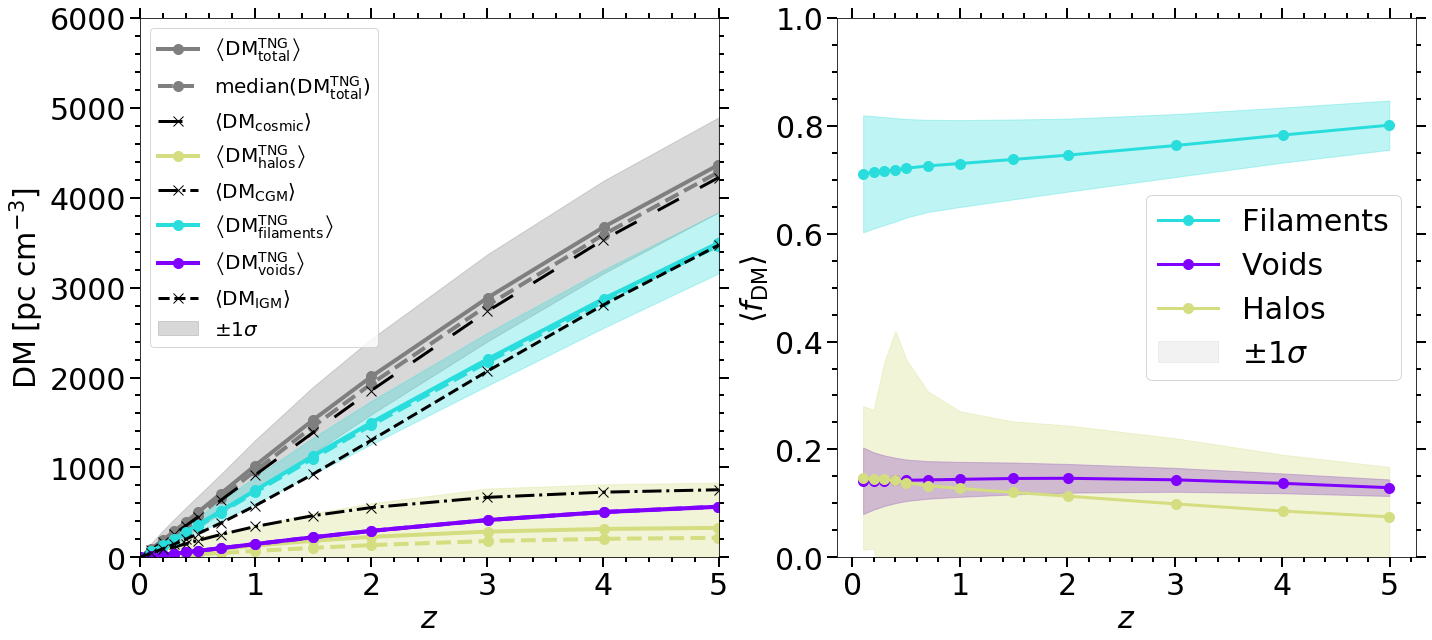

In [68]:
##################
#initialise plots#
##################
col = plt.cm.rainbow(np.linspace(0,1,4)) #create a list of colours from the colourmap which match those from plot in Paper_Plots_IF_vs_DM_3.ipynb

fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.set_xlabel(r'$z$',fontsize=30)
ax1.set_ylabel(r'${\rm DM\;[pc\;cm^{-3}]}$',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xlim([0,5.])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax1.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_ylim([0,6000])

#############################################################################
#Plot breakdowns vs theoretical+empirical DMcosmic + breakdowns (FRB github)#
#############################################################################

ax1.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{total}}\right>$')
ax1.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='--',label=r'${\rm median(DM^{TNG}_{total})}$')
ax1.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.3,color='C7',label=r'$\pm1\sigma$')
ax1.plot(theory_z_2,cosm_theory_2,marker='x',markersize=10,dashes=(8,8),color='k',ls='-',lw=3,alpha=1,label=r'$\left<{\rm DM_{cosmic}}\right>$')

ax1.plot(snap_z_list,
         mean_Hal_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[2],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{halos}}\right>$')
ax1.plot(snap_z_list,
         medi_Hal_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[2],lw=4,alpha=1,ls='--')
ax1.fill_between(snap_z_list,
                 mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,
                 mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,
                 alpha=0.3,color=col[2])

ax1.plot(theory_z_2,halo_theory_2,marker='x',markersize=10,color='k',ls='-.',lw=3,alpha=1,label=r'$\left<{\rm DM_{CGM}}\right>$')

ax1.plot(snap_z_list,
         mean_Fil_cDM_arr_Zhang,
         marker='o',markersize=10,color=col[1],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{filaments}}\right>$')
ax1.plot(snap_z_list,
         medi_Fil_cDM_arr_Zhang,
         marker='o',markersize=10,color=col[1],lw=4,alpha=1,ls='--')
ax1.fill_between(snap_z_list,
                 mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,
                 mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,
                 alpha=0.3,color=col[1])

ax1.plot(snap_z_list,
         mean_Voi_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[0],lw=4,alpha=1,ls='-',label=r'$\left<{\rm DM^{TNG}_{voids}}\right>$')
ax1.plot(snap_z_list,
         medi_Voi_cDM_arr_Pakmor,
         marker='o',markersize=10,color=col[0],lw=4,alpha=1,ls='--')
ax1.fill_between(snap_z_list,
                 mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,
                 mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,
                 alpha=0.3,color=col[0])

ax1.plot(theory_z_2,igm_theory_2,marker='x',markersize=10,color='k',ls='--',lw=3,alpha=1,label=r'$\left<{\rm DM_{IGM}}\right>$')



ax1.legend(fontsize=20)

##############################
#plot fractional DM evolution#
##############################

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r'$z$',fontsize=30)
ax2.set_ylabel(r'$\left<f_{\rm DM}\right>$',fontsize=30)
ax2.set_ylim([0,1])
ax2.set_xlabel(r'$z$',fontsize=30)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax2.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax2.xaxis.get_ticklocs(minor=True)
ax2.tick_params(axis='x', which='minor')
ax2.minorticks_on()

#################
#Do the plotting#
#################

#plot average filamentary contribution as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Fil_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[1],label='Filaments')

#plot stdv of filamentary contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Fil_upper_bound'],
                 read_fig_arrays['Fil_lower_bound'],
                 alpha=0.3,color=col[1])

#plot average void contributions as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Voi_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[0],label='Voids')

#plot stdv of void contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Voi_upper_bound'],
                 read_fig_arrays['Voi_lower_bound'],
                 alpha=0.3,color=col[0])

#also plot placeholder for legend purposes
ax2.fill_between(snap_z_list,
                 read_fig_arrays['Voi_upper_bound'],
                 read_fig_arrays['Voi_lower_bound'],
                 alpha=0.1,color='gray',label=r'$\pm1\sigma$')

#plot average halo contributions as a function of z
ax2.plot(read_fig_arrays['snap_z_list'],
         read_fig_arrays['mean_Hal_cDM_arr_Pakmor']/read_fig_arrays['mean_cDM_arr_Pakmor'],
         ls='-',
         alpha=1,
         lw=3,
         marker='o',
         markersize=10,
         color=col[2],label='Halos')

#plot stdv of halo contributions
ax2.fill_between(read_fig_arrays['snap_z_list'],
                 read_fig_arrays['Hal_upper_bound'],
                 read_fig_arrays['Hal_lower_bound'],
                 alpha=0.3,color=col[2])


ax2.legend(fontsize=30)


plt.tight_layout()
#plt.savefig('Paper_Plot_DM_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Plot DM evolution vs prev. literature split into two subplots

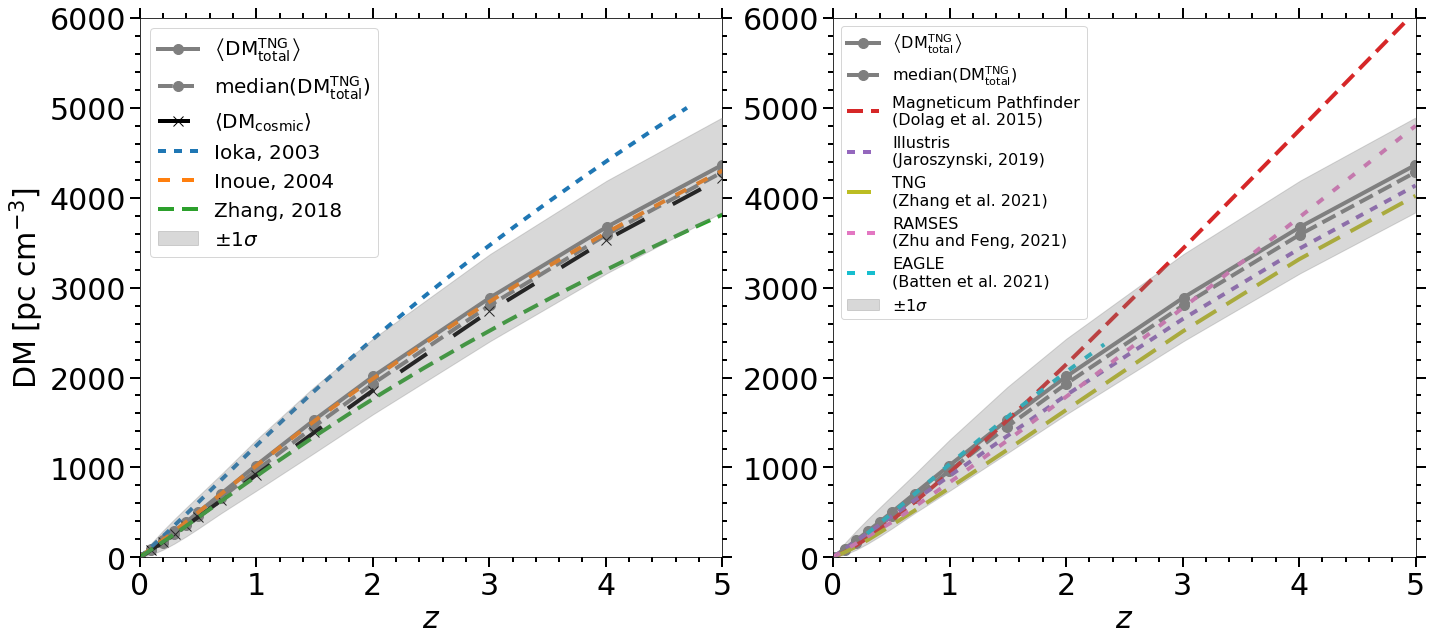

In [66]:
##################
#initialise plots#
##################
col = plt.cm.rainbow(np.linspace(0,1,4)) #create a list of colours from the colourmap which match those from plot in Paper_Plots_IF_vs_DM_3.ipynb

fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(121)
ax1.set_xlabel(r'$z$',fontsize=30)
ax1.set_ylabel(r'${\rm DM\;[pc\;cm^{-3}]}$',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xlim([0,5.])
ax1.set_ylim([0,6000])
#ax1.set_ylim([50,5000])
#ax1.set_yscale('log')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax1.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax1.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r'$z$',fontsize=30)
#ax2.set_ylabel(r'${\rm DM\;[pc\;cm^{-3}]}$',fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.set_xlim([0,5.])
ax2.set_ylim([0,6000])
#ax1.set_ylim([50,5000])
#ax1.set_yscale('log')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='x', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='y', width=2, length=10, which='major',labelsize=30)
ax2.tick_params(axis='x', width=2, length=5, which='minor',labelsize=30)
ax2.tick_params(axis='y', width=2, length=5, which='minor',labelsize=30)
ax2.xaxis.get_ticklocs(minor=True)
ax2.minorticks_on()



#################################################
#plot TNG DM total vs previous work 1 (fruitbat)#
#################################################

ax1.plot(snap_z_list,
         mean_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='-',zorder=1,
         label=r'$\left<{\rm DM^{TNG}_{total}}\right>$')
ax1.plot(snap_z_list,
         medi_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='--',zorder=2,
         label=r'${\rm median(DM^{TNG}_{total})}$')
ax1.fill_between(snap_z_list,
                 mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,
                 mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.3,color='C7',zorder=3,
                 label=r'$\pm1\sigma$')


ax1.plot(theory_z_2,
         cosm_theory_2,
         marker='x',markersize=10,color='k',ls='-',lw=4,alpha=1,dashes=(8,8),
         label=r'$\left<{\rm DM_{cosmic}}\right>$')

####################################################
#plot the analytical estimates in Left-hand subplot#
####################################################

#ioka: https://ui.adsabs.harvard.edu/abs/2003ApJ...598L..79I/abstract
ax1.plot(fb_ioka_z_vals,fb_dm_vals,label='Ioka, 2003',
        lw=4,ls='-.',dashes=(2, 2),color='C0')

#inoue: https://ui.adsabs.harvard.edu/abs/2004MNRAS.348..999I/abstract
ax1.plot(fb_inoue_z_vals,fb_dm_vals,label='Inoue, 2004',
        lw=4,ls='--',dashes=(3, 3),color='C1')

#zhang: https://ui.adsabs.harvard.edu/abs/2018ApJ...867L..21Z/abstract
ax1.plot(fb_zhang_z_vals,fb_dm_vals,label='Zhang, 2018',
        lw=4,ls='--',dashes=(4, 2),color='C2')


ax1.legend(fontsize=20,loc=2)




#################################################
#plot TNG DM total vs previous work 2 (fruitbat)#
#################################################


ax2.plot(snap_z_list,
         mean_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='-',zorder=1,
         label=r'$\left<{\rm DM^{TNG}_{total}}\right>$')
ax2.plot(snap_z_list,
         medi_cDM_arr_Pakmor,
         marker='o',markersize=10,color='C7',lw=4,alpha=1,ls='--',zorder=2,
         label=r'${\rm median(DM^{TNG}_{total})}$')
ax2.fill_between(snap_z_list,
                 mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,
                 mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.3,color='C7',zorder=3,
                 label=r'$\pm1\sigma$')


#############################################################
#plot the other simulation lit results in right-hand subplot#
#############################################################

#pol: https://ui.adsabs.harvard.edu/abs/2019ApJ...886..135P/abstract
#ax1.plot(pol_z_vals,pol_dm_vals*(np.array(pol_z_vals)+1),label='MICE (Pol et al. 2019)')
#ax1.plot(pol_z_vals,pol_dm_vals,label='MICE (Pol et al. 2019)')

#dolag: https://ui.adsabs.harvard.edu/abs/2015MNRAS.451.4277D/abstract
ax2.plot(d_z_vals,d_dm_vals,label='Magneticum Pathfinder\n(Dolag et al. 2015)',
        lw=4,ls='-.',dashes=(4, 2),color='C3')

#jaroszynski: https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.1637J/abstract
ax2.plot(j_z_vals,j_dm_vals,label='Illustris\n(Jaroszynski, 2019)',
        lw=4,ls=':',dashes=(2, 2),color='C4')


#zhang: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...49Z/abstract
ax2.plot(z_z_vals,z_dm_vals,label='TNG\n(Zhang et al. 2021)',
        lw=4,ls='--',dashes=(6,3),color='C8')

#zhu: https://ui.adsabs.harvard.edu/abs/2021ApJ...906...95Z/abstract
ax2.plot(zhu_z_vals,zhu_dm_vals,label='RAMSES\n(Zhu and Feng, 2021)',
        lw=4,ls=':',dashes=(2,3),color='C6')

#batten: https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5356B/abstract
ax2.plot(fb_batten_z_vals[0:10],fb_dm_vals[0:10],label='EAGLE\n(Batten et al. 2021)',
        lw=4,ls='-.',dashes=(2,3),color='C9')



ax2.legend(fontsize=16)



plt.tight_layout()
#plt.savefig('Paper_Plot_DM_{0}.png'.format(sim_to_load),format='png')
plt.show()